# Quantum Control: X, Y, X90, Y90 Gate Optimization and Benchmarking

This notebook mirrors the gate-optimization and randomized benchmarking flow used for Hadamard/S/T gates, but targets four additional single-qubit gates:

- X (pi rotation about X)
- Y (pi rotation about Y)
- X90 (pi/2 rotation about X)
- Y90 (pi/2 rotation about Y)

Structure:
1. Optimize each gate using the IQ PTM-based cost in `src/optimization.py`.
2. Run a simplified randomized benchmarking-style sequence fidelity scan for each optimized pulse using helpers in `src/benchmarking.py`.

In [1]:
# Import the modular quantum control framework
import numpy as np
import matplotlib.pyplot as plt
import time
import importlib
import src.benchmarking as bm
from src import run_sequence_benchmark, benchmarking_summary
from pprint import pprint
import pandas as pd
from qutip import Bloch, ptrace, basis, sigmax, sigmay, sigmaz, expect
import numpy as np
import time

# Import our modular framework components
from src import (
    # Configuration and constants
    time_array, DEFAULT_FOURIER_MODES, QUBIT_FREQUENCY, CAVITY_FREQUENCY, COUPLING_STRENGTH,
    CAVITY_DISSIPATION, QUBIT_DISSIPATION, QUBIT_DEPHASING,
    
    # Core quantum mechanics
    get_initial_state, create_operators, construct_system_hamiltonian,
    simulate_controlled_evolution,
    
    # Visualization
    QuantumControlPlotter,
)

from src.operators import get_collapse_operators
from src.dynamics import simulate_controlled_evolution, compute_fourier_control_field, simulate_controlled_evolution_iq, compute_iq_control_fields
from src.utils import build_iq_vector, split_iq_vector
import src.optimization as _opt

# Initialize plotter (disable LaTeX for portability here)
plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

print(f"Quantum Control Framework Initialized")
print(f"System Parameters:")
print(f"  Cavity frequency: {CAVITY_FREQUENCY/(2*np.pi):.3f} GHz")
print(f"  Qubit frequency: {QUBIT_FREQUENCY/(2*np.pi):.3f} GHz")
print(f"  Coupling strength: {COUPLING_STRENGTH/(2*np.pi):.3f} GHz")
print(f"  Evolution time: {time_array[-1]:.1f} ns")
print(f"  Fourier modes: {DEFAULT_FOURIER_MODES}")

Quantum Control Framework Initialized
System Parameters:
  Cavity frequency: 3.000 GHz
  Qubit frequency: 1.000 GHz
  Coupling strength: 0.100 GHz
  Evolution time: 10.0 ns
  Fourier modes: 32


In [2]:
# Initialize quantum system components
initial_state = get_initial_state()
operators = create_operators()
collapse_ops = get_collapse_operators(gamma_cavity=CAVITY_DISSIPATION, # ~ 0.1-5 MHz
                                      gamma_qubit=QUBIT_DISSIPATION, # ~ 1-10 KHz
                                      gamma_dephasing=QUBIT_DEPHASING # ~ 1-20 KHz
)

print(f"Initial state: Ground state |g,0⟩")
print(f"Hilbert space dimension: {initial_state.shape[0]}")
print(f"System operators created: {len(operators)} operators")

# System parameters for dynamics simulation
system_params = {
    'omega_r': CAVITY_FREQUENCY,
    'omega_t': QUBIT_FREQUENCY,
    'coupling_g': COUPLING_STRENGTH
}

Initial state: Ground state |g,0⟩
Hilbert space dimension: 10
System operators created: 18 operators


# Quantum Control: X, Y, X90, Y90 Gate Optimization and Benchmarking

This notebook mirrors the gate-optimization and randomized benchmarking flow used for Hadamard/S/T gates, but targets four additional single-qubit gates:

- X (pi rotation about X)
- Y (pi rotation about Y)
- X90 (pi/2 rotation about X)
- Y90 (pi/2 rotation about Y)

Structure:
1. Optimize each gate using the IQ PTM-based cost in `src/optimization.py`.
2. Run a simplified randomized benchmarking-style sequence fidelity scan for each optimized pulse using helpers in `src/benchmarking.py`.

In [ ]:
# Helper: extract single-qubit expectation values (σx, σy, σz) from composite states list
def extract_qubit_expectations(states_list):
    ex, ey, ez = [], [], []    
    for st in states_list:
        rho_qubit = ptrace(st, 1)  # subsystem index 1 assumed to be qubit
        ex.append(expect(sigmax(), rho_qubit).real)
        ey.append(expect(sigmay(), rho_qubit).real)
        ez.append(expect(sigmaz(), rho_qubit).real)
    return np.array(ex), np.array(ey), np.array(ez)

# Ideal target single-qubit states starting from |g>
ket_g = basis(2,0)
ket_e = basis(2,1)
psi_ideal = {
    'hadamard': (ket_g + ket_e).unit(),  # (|g> + |e>)/√2
    's_gate' : ket_g,                    # S gate leaves |g> unchanged
    't_gate' : ket_g,                     # T gate leaves |g> unchanged
    'x_gate' : ket_e,                     # X gate flips |g> to |e>
    'x90_gate' : (ket_g - 1j * ket_e).unit(),  # X90 gate
    'y_gate' : ket_e,   # Y gate flips |g>  to |e>
    'y90_gate' : (ket_g + ket_e).unit(),  # Y90 gate
}

def bloch_coords(state):
    return [float(np.real(expect(sigmax(), state))),
            float(np.real(expect(sigmay(), state))),
            float(np.real(expect(sigmaz(), state)))]

ideal_bloch = { name: bloch_coords(st) for name, st in psi_ideal.items() }

missing = []
for fn_name in ['optimize_hadamard_gate','optimize_s_gate','optimize_t_gate']:
    if not hasattr(_opt, fn_name):
        missing.append(fn_name)
if missing:
    print("Missing gate optimization functions in src.optimization:", missing)
else:
    optimize_hadamard_gate = _opt.optimize_hadamard_gate  # type: ignore
    optimize_s_gate = _opt.optimize_s_gate  # type: ignore
    optimize_t_gate = _opt.optimize_t_gate  # type: ignore
    optimize_x_gate = _opt.optimize_x_gate  # type: ignore
    optimize_x90_gate = _opt.optimize_x90_gate  # type: ignore
    optimize_y_gate = _opt.optimize_y_gate  # type: ignore
    optimize_y90_gate = _opt.optimize_y90_gate  # type: ignore
    print("All gate optimization functions loaded.")

# Container accumulating per-gate results
gate_results = {}
print("Gate optimization environment ready.")

All gate optimization functions loaded.
Gate optimization environment ready.


In [ ]:
# results_load = np.load('results/x_gate/opt_x_gate_iq_modes=4_iters=1_cost=1.287e-04_20250820T142259.npz', allow_pickle=True)
# x_opt_coeffs = build_iq_vector(results_load['optimal_coefficients_I'], results_load['optimal_coefficients_Q'])
# x_opt_sim = simulate_controlled_evolution(
#     time_array,
#     fourier_coefficients=x_opt_coeffs,
#     drive_period=time_array[-1],
#     system_params=system_params,
#     initial_state=initial_state,
#     collapse_ops=collapse_ops
# )
# ex_x, ey_x, ez_x = extract_qubit_expectations(x_opt_sim['states'])

# control_field_x = compute_fourier_control_field(time_array, x_opt_coeffs, float(time_array[-1]))
# gate_plotter = plotter
# gate_plotter.plot_bloch_components(time_array, ex_x, ey_x, ez_x, ideal_vector=None, gate_name='X Gate')
# gate_plotter.plot_control_field_analysis(time_array, control_field_x.real, 
#                                          fourier_coefficients=x_opt_coeffs, title='X Gate Control Field Analysis')

In [17]:
# Run Y gate optimization
start = time.time()
y_opt_res = optimize_y_gate(
    fourier_modes=16, max_iterations=6,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=None
)
elapsed = time.time() - start
    
# Simulate trajectory with optimal coefficients
y_opt_sim = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res['optimization_result'].x,
    drive_period=y_opt_res['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y, ey_y, ez_y = extract_qubit_expectations(y_opt_sim['states'])

# Store
y_opt_cost = y_opt_res['optimization_result'].fun
y_opt_fid = 1 - y_opt_cost
gate_results['y_gate'] = {
    'result': y_opt_res,
    'traj': (ex_y, ey_y, ez_y),
    'cost': y_opt_cost,
    'fidelity': y_opt_fid,
    'time_elapsed': elapsed
}

print(f"Y gate optimization complete: cost={y_opt_cost:.3e}, fidelity={y_opt_fid:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {y_opt_res['nfev']}")

Starting global optimization with 6 random initializations...
Parameter space dimension: 32
Optimization method: L-BFGS-B
Variable bounds: (-0.32, 0.32)
------------------------------------------------------------
Iteration 1: Parameters = 32, Cost = 3.946590e-03
Iteration 2: Parameters = 32, Cost = 1.539889e-04
  → New best solution found!
Iteration 3: Parameters = 32, Cost = 1.267094e-04
  → New best solution found!
Iteration 4: Parameters = 32, Cost = 1.341788e-04
Iteration 5: Parameters = 32, Cost = 1.271153e-04
Iteration 6: Parameters = 32, Cost = 1.423805e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.267094e-04
Optimization success: True
Function evaluations: 1155
Y gate optimization complete: cost=1.267e-04, fidelity=0.9999, time=658.99s
Time elapsed: 658.99 seconds
Total function evaluations: 4158


In [4]:
y_opt_res = np.load(f'data/payloads/y_gate/y_opt_res.npz', allow_pickle=True)['y_opt_res'].item()

# Simulate trajectory with optimal coefficients
y_opt_sim = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res['optimization_result'].x,
    drive_period=y_opt_res['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y, ey_y, ez_y = extract_qubit_expectations(y_opt_sim['states'])

# Store
y_opt_cost = y_opt_res['optimization_result'].fun
y_opt_fid = 1 - y_opt_cost
gate_results['y_gate'] = {
    'result': y_opt_res,
    'traj': (ex_y, ey_y, ez_y),
    'cost': y_opt_cost,
    'fidelity': y_opt_fid,
    'time_elapsed': 658.99
}

print(f"Y gate optimization complete: cost={y_opt_cost:.3e}, fidelity={y_opt_fid:.4f}, time={658.99:.2f}s")
print(f"Time elapsed: {658.99:.2f} seconds")
print(f"Total function evaluations: {y_opt_res['nfev']}")

Y gate optimization complete: cost=1.267e-04, fidelity=0.9999, time=658.99s
Time elapsed: 658.99 seconds
Total function evaluations: 4158


Figure saved: results/y_gate_bloch_components.png


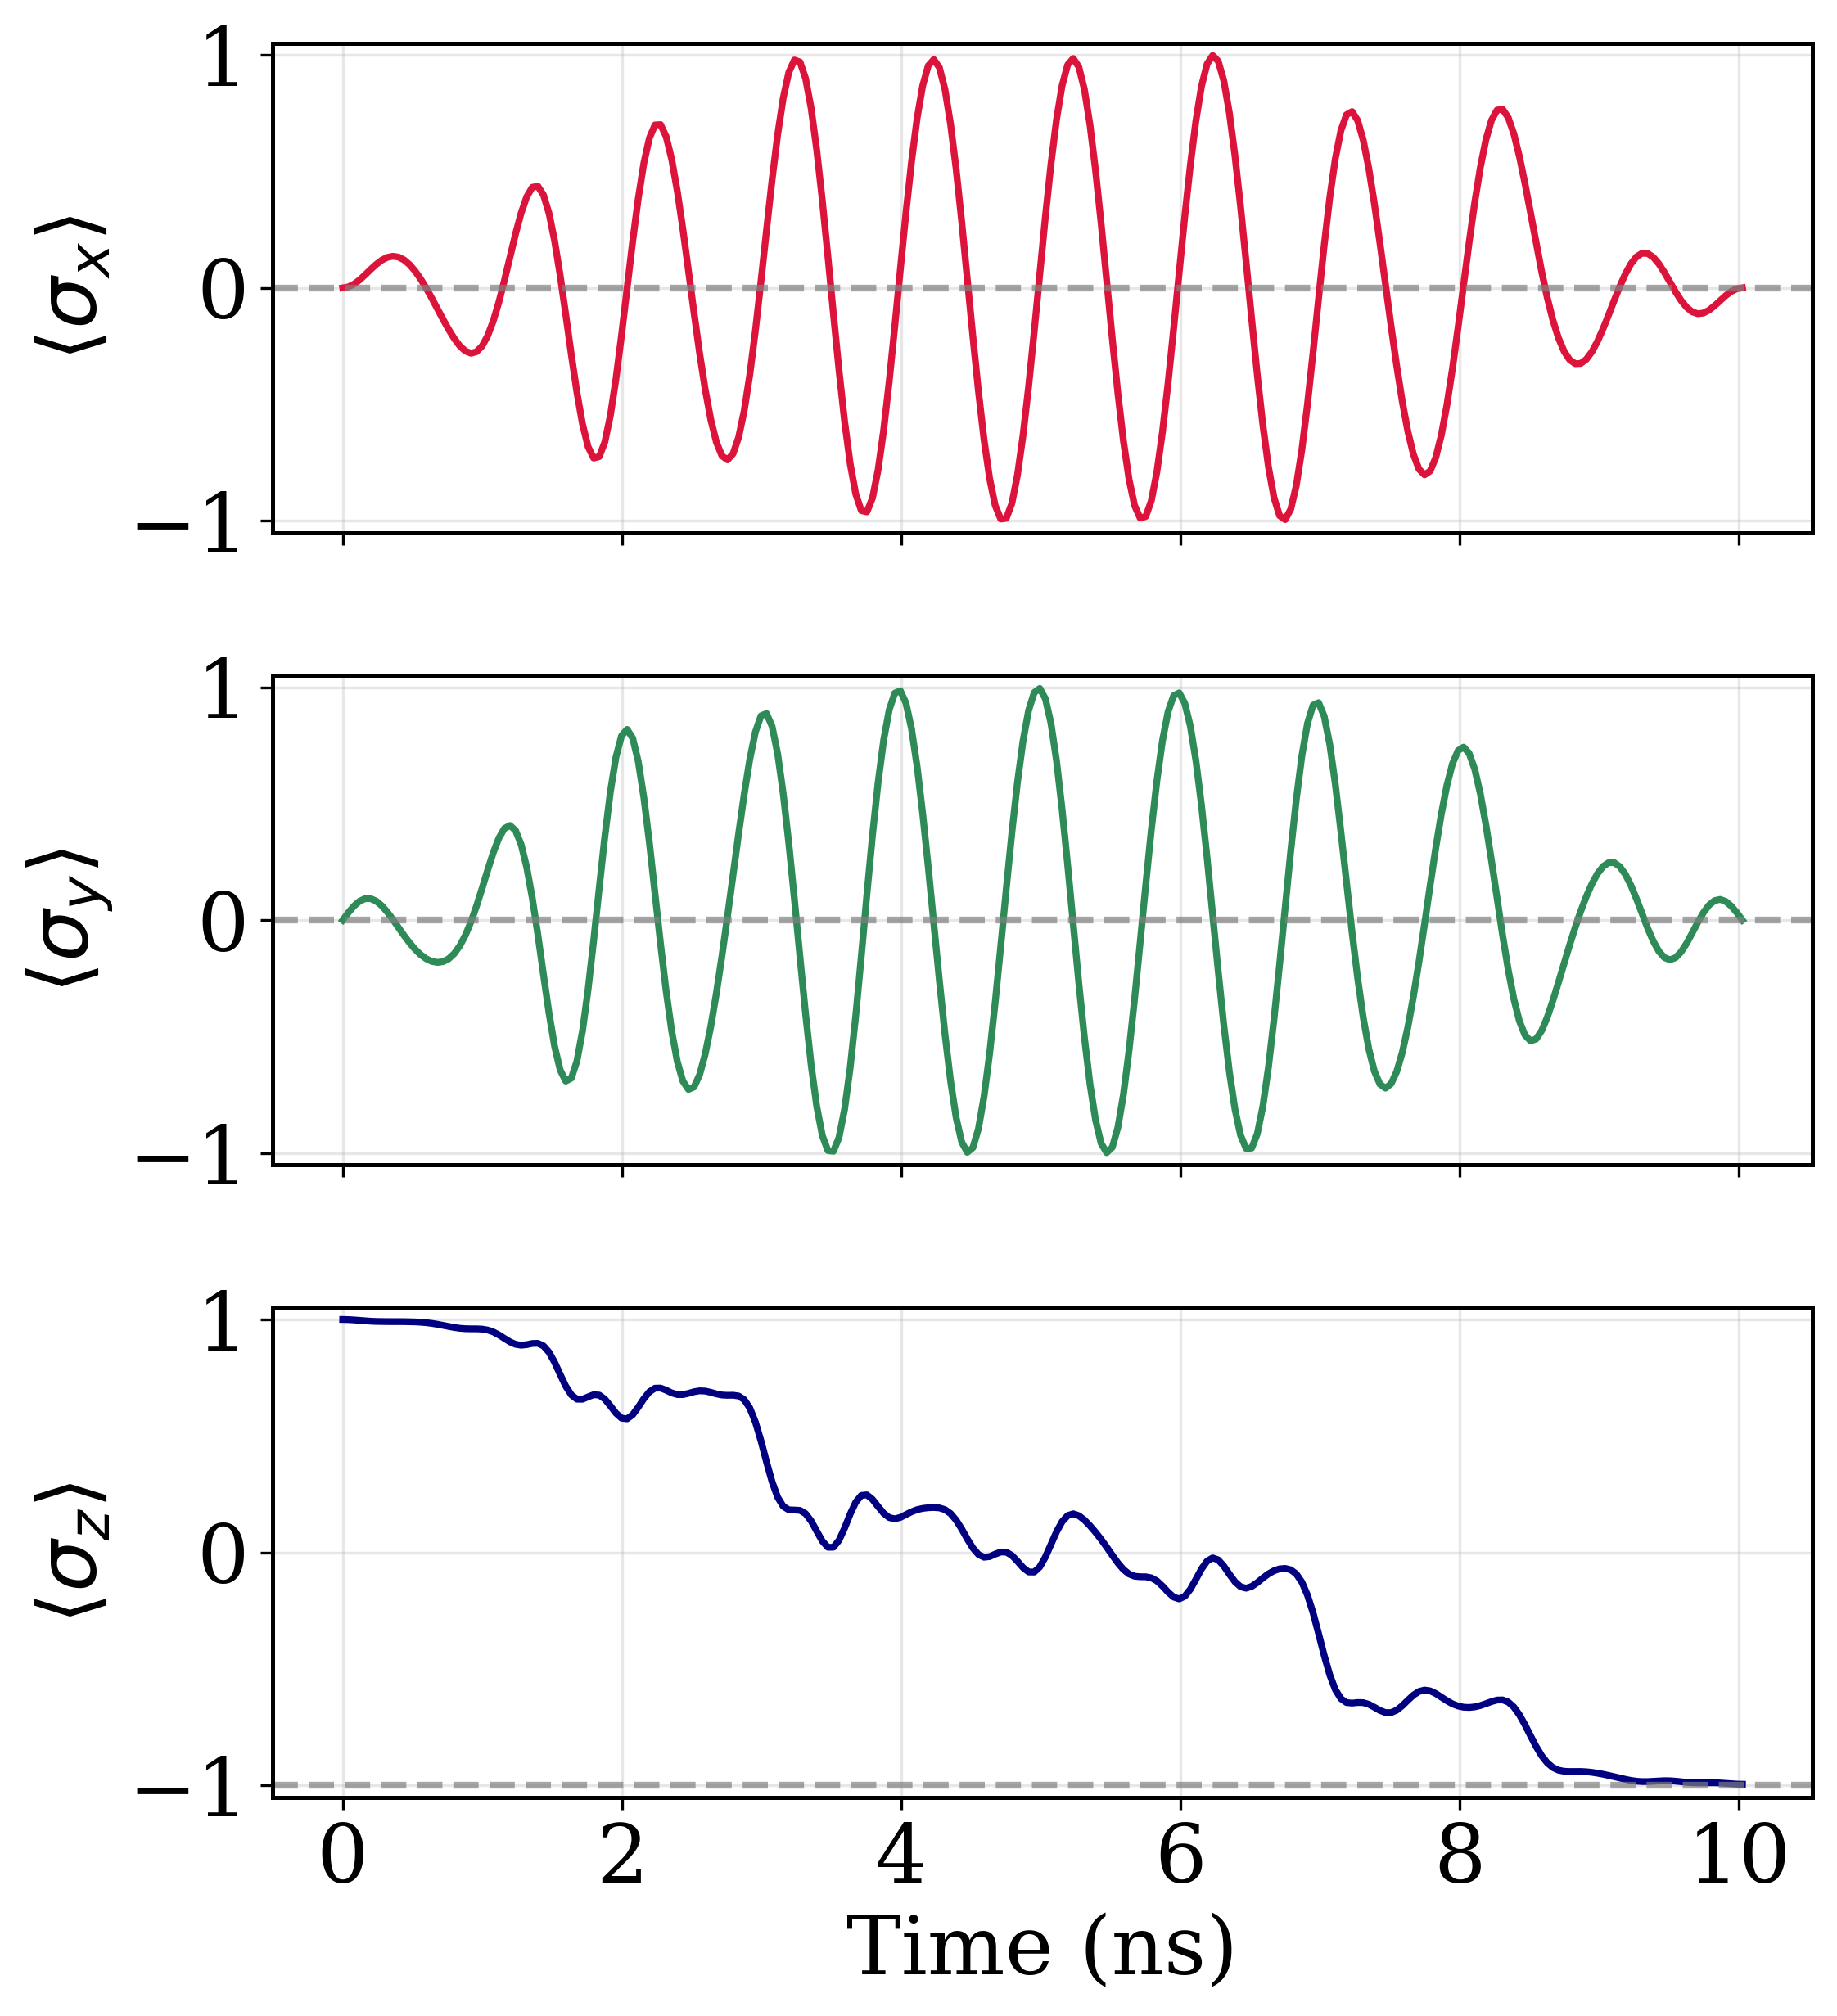

Figure saved: results/y_gate_bloch_trajectory.png


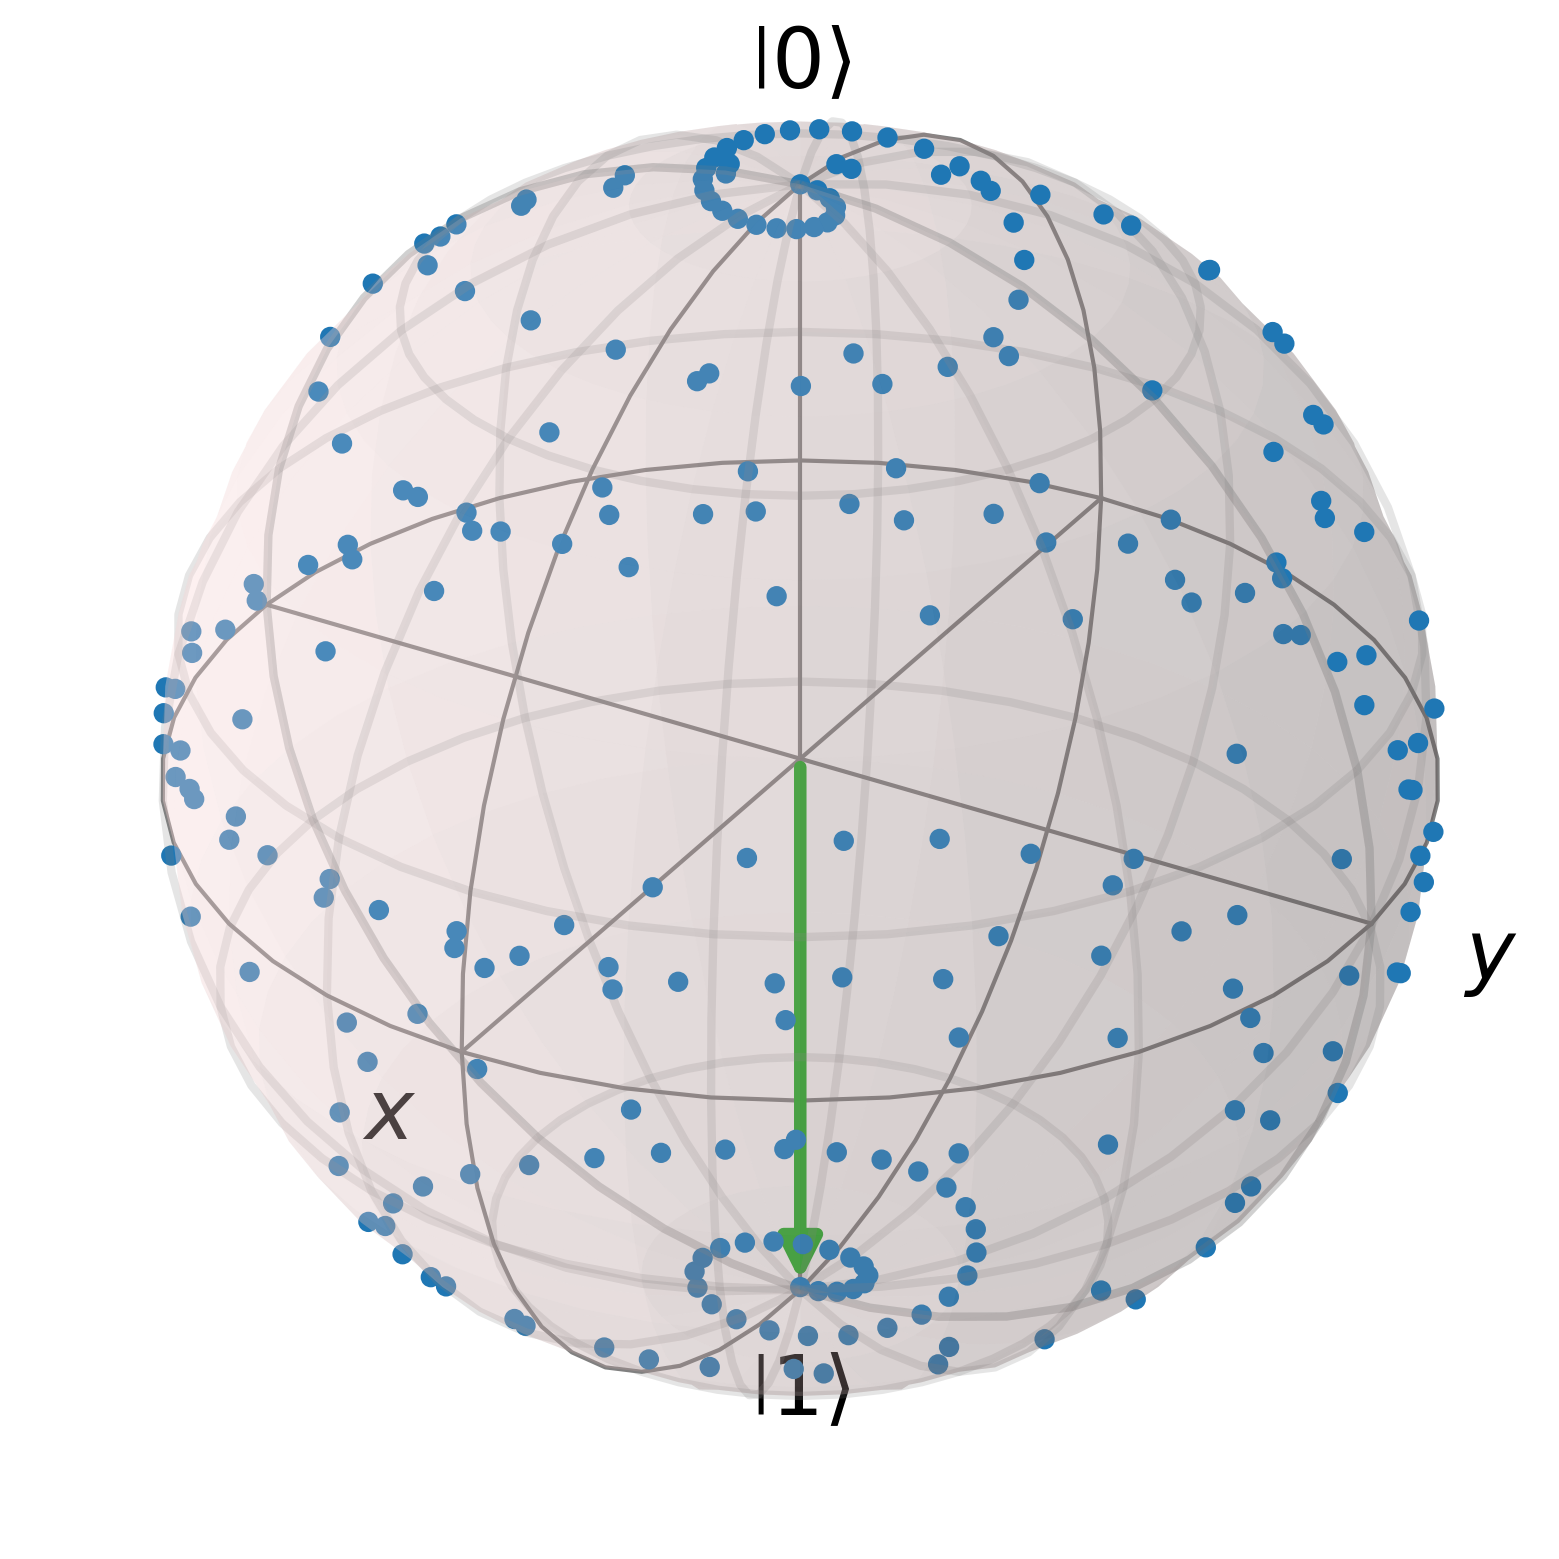

Figure saved: results/y_gate_control_field_analysis.png


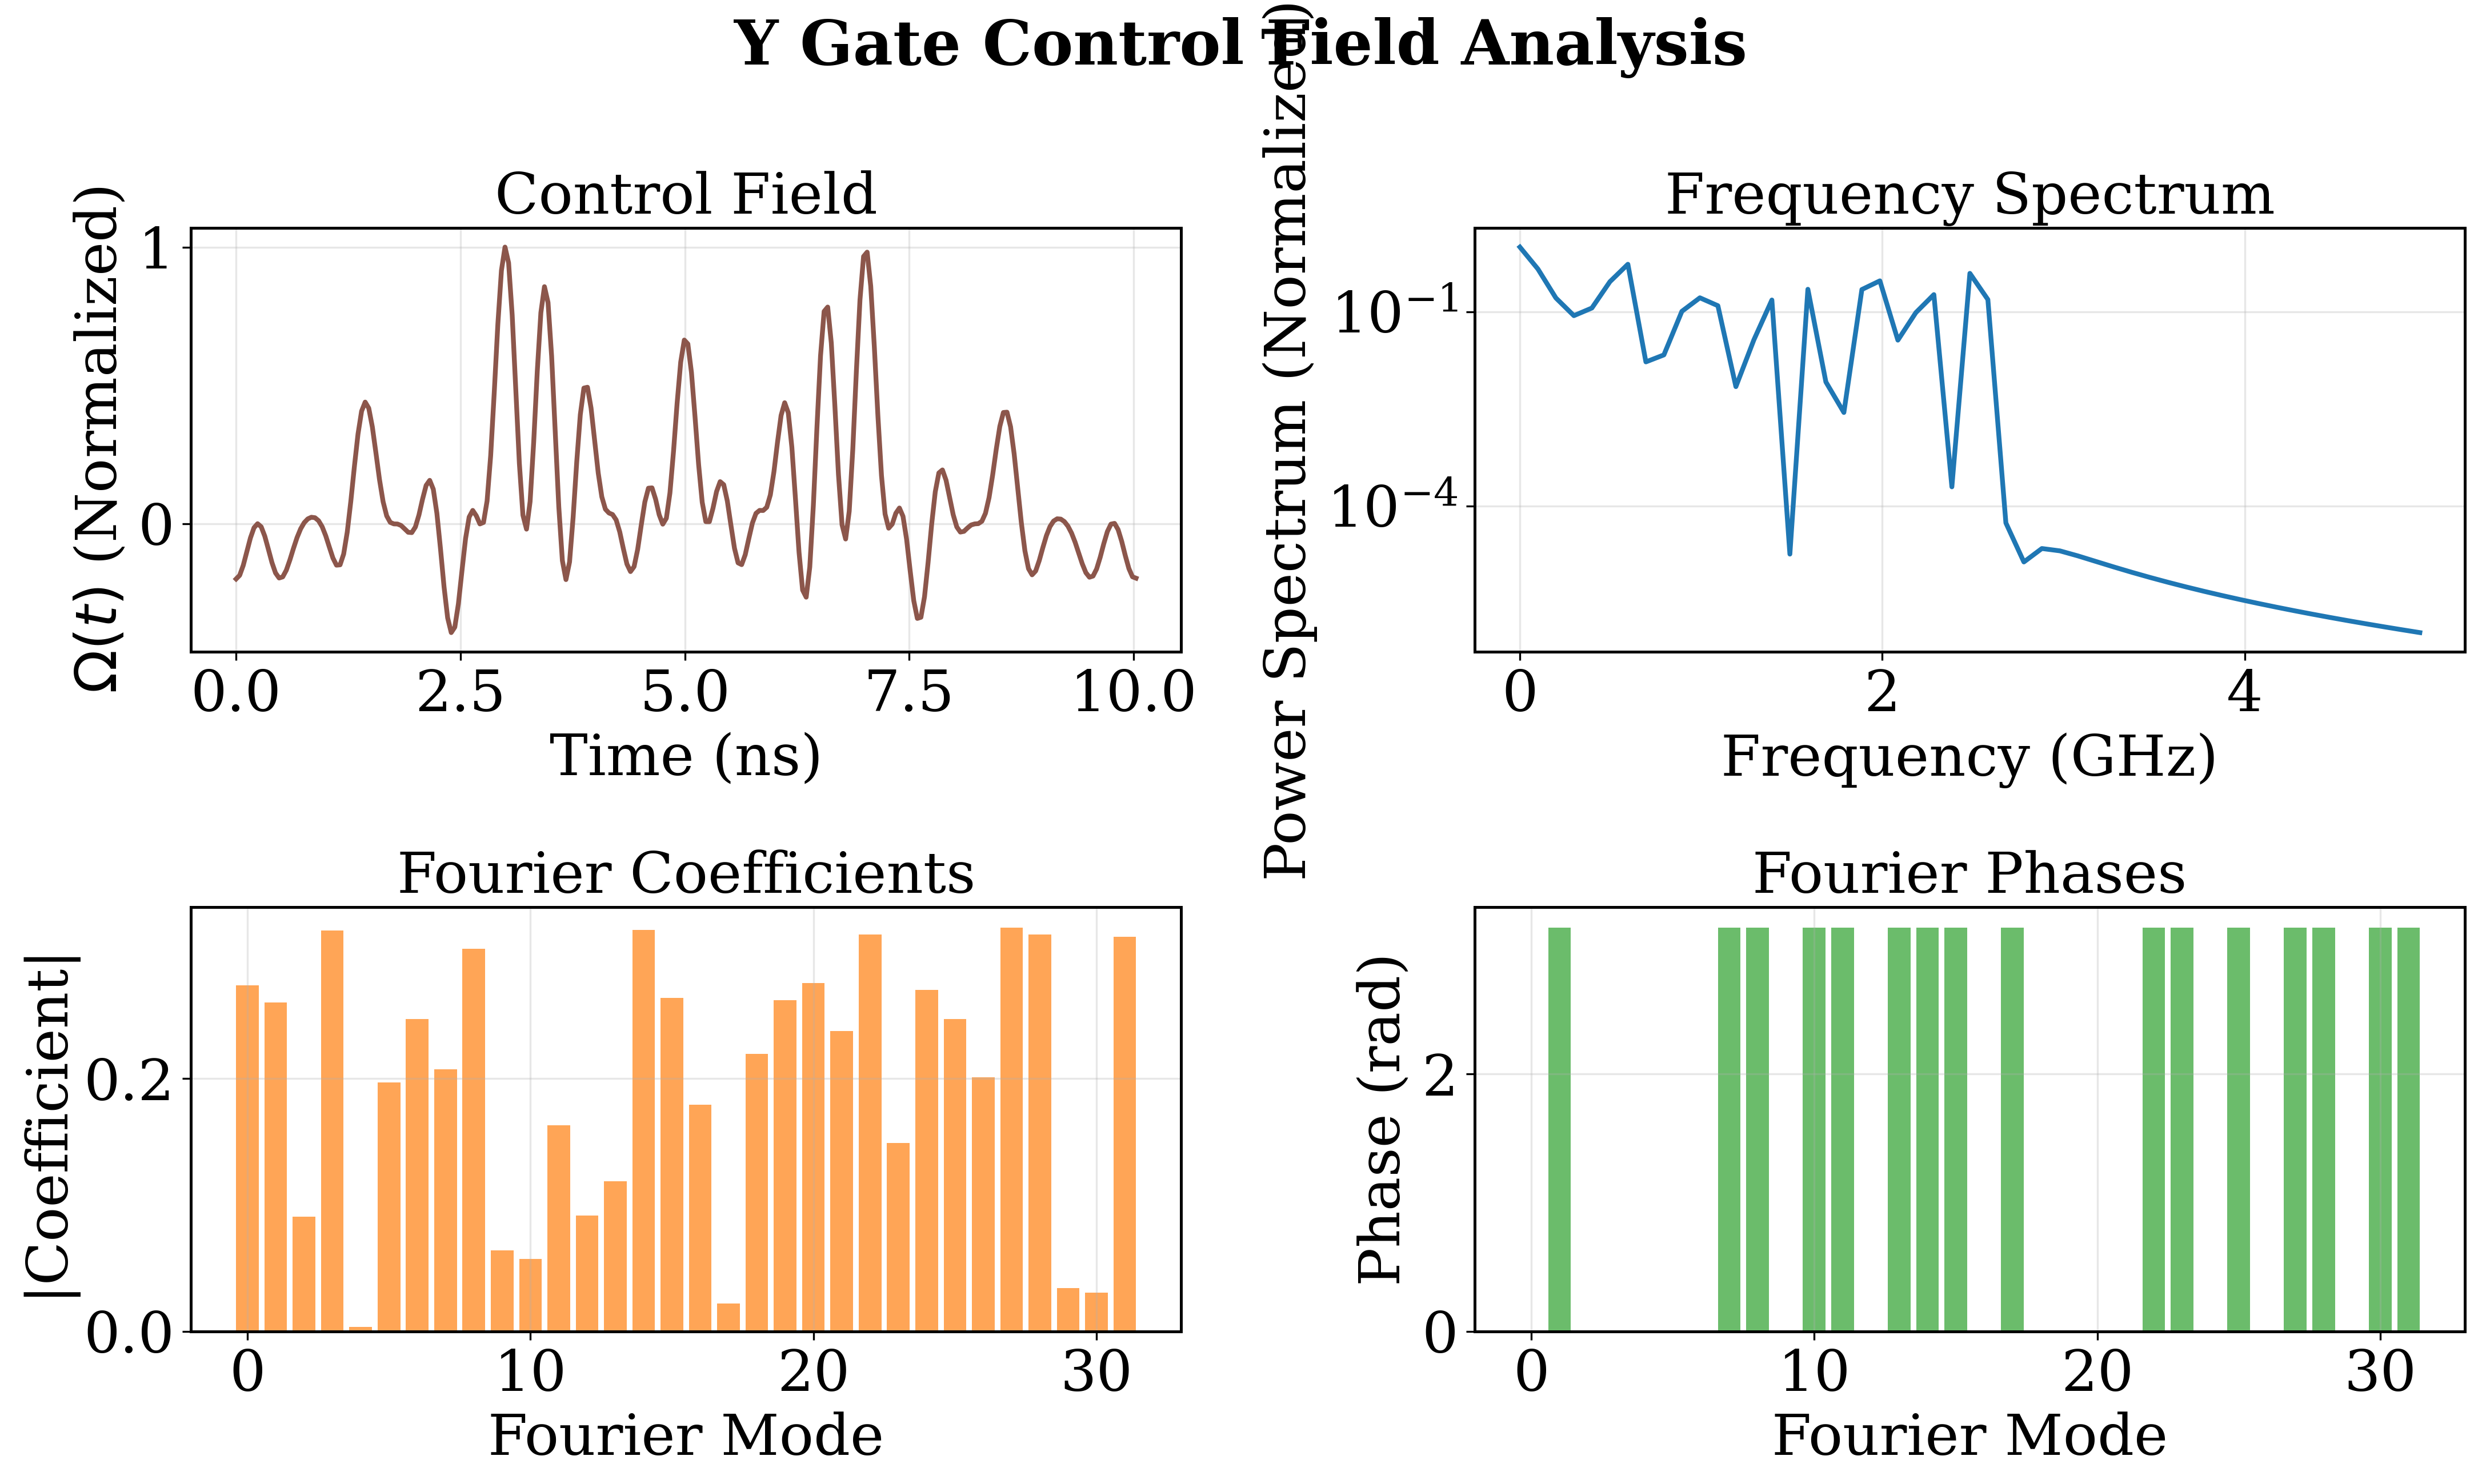

Y Gate final Bloch vector: [0.00025241991100198976, 1.5031383031061427e-05, -0.9947625119477288]
Y Gate ideal Bloch vector: [0.0, 0.0, -1.0]
Y Gate Bloch vector error (L2): 0.0052
Y Gate fidelity (stored): 0.9999


In [5]:
# Y Gate: Refactored Plotting Using Plotting Module
y_opt_coeffs = gate_results['y_gate']['result']['optimization_result'].x
y_opt_period = gate_results['y_gate']['result']['control_period']
control_field_y = compute_fourier_control_field(time_array, y_opt_coeffs, y_opt_period)
ex_y, ey_y, ez_y = gate_results['y_gate']['traj']
ideal_vec_y = ideal_bloch['y_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_y, ey_y, ez_y, ideal_vector=ideal_vec_y, gate_name='Y Gate',
                                   filename='y_gate_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_y, ey_y, ez_y, ideal_vector=ideal_vec_y, gate_name='Y Gate',
                                    filename='y_gate_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_y.real,
                                         fourier_coefficients=y_opt_coeffs, title='Y Gate Control Field Analysis',
                                         filename='y_gate_control_field_analysis.png')

final_vec_y = [ex_y[-1], ey_y[-1], ez_y[-1]]
err_y = np.linalg.norm(np.array(final_vec_y) - np.array(ideal_vec_y))
print(f"Y Gate final Bloch vector: {final_vec_y}")
print(f"Y Gate ideal Bloch vector: {ideal_vec_y}")
print(f"Y Gate Bloch vector error (L2): {err_y:.4f}")
print(f"Y Gate fidelity (stored): {gate_results['y_gate']['fidelity']:.4f}")

In [13]:
initial_guess_y = np.load('data/y_gate_prediction.npz')['prediction_physical'][0]
initial_guess_y.shape

(32,)

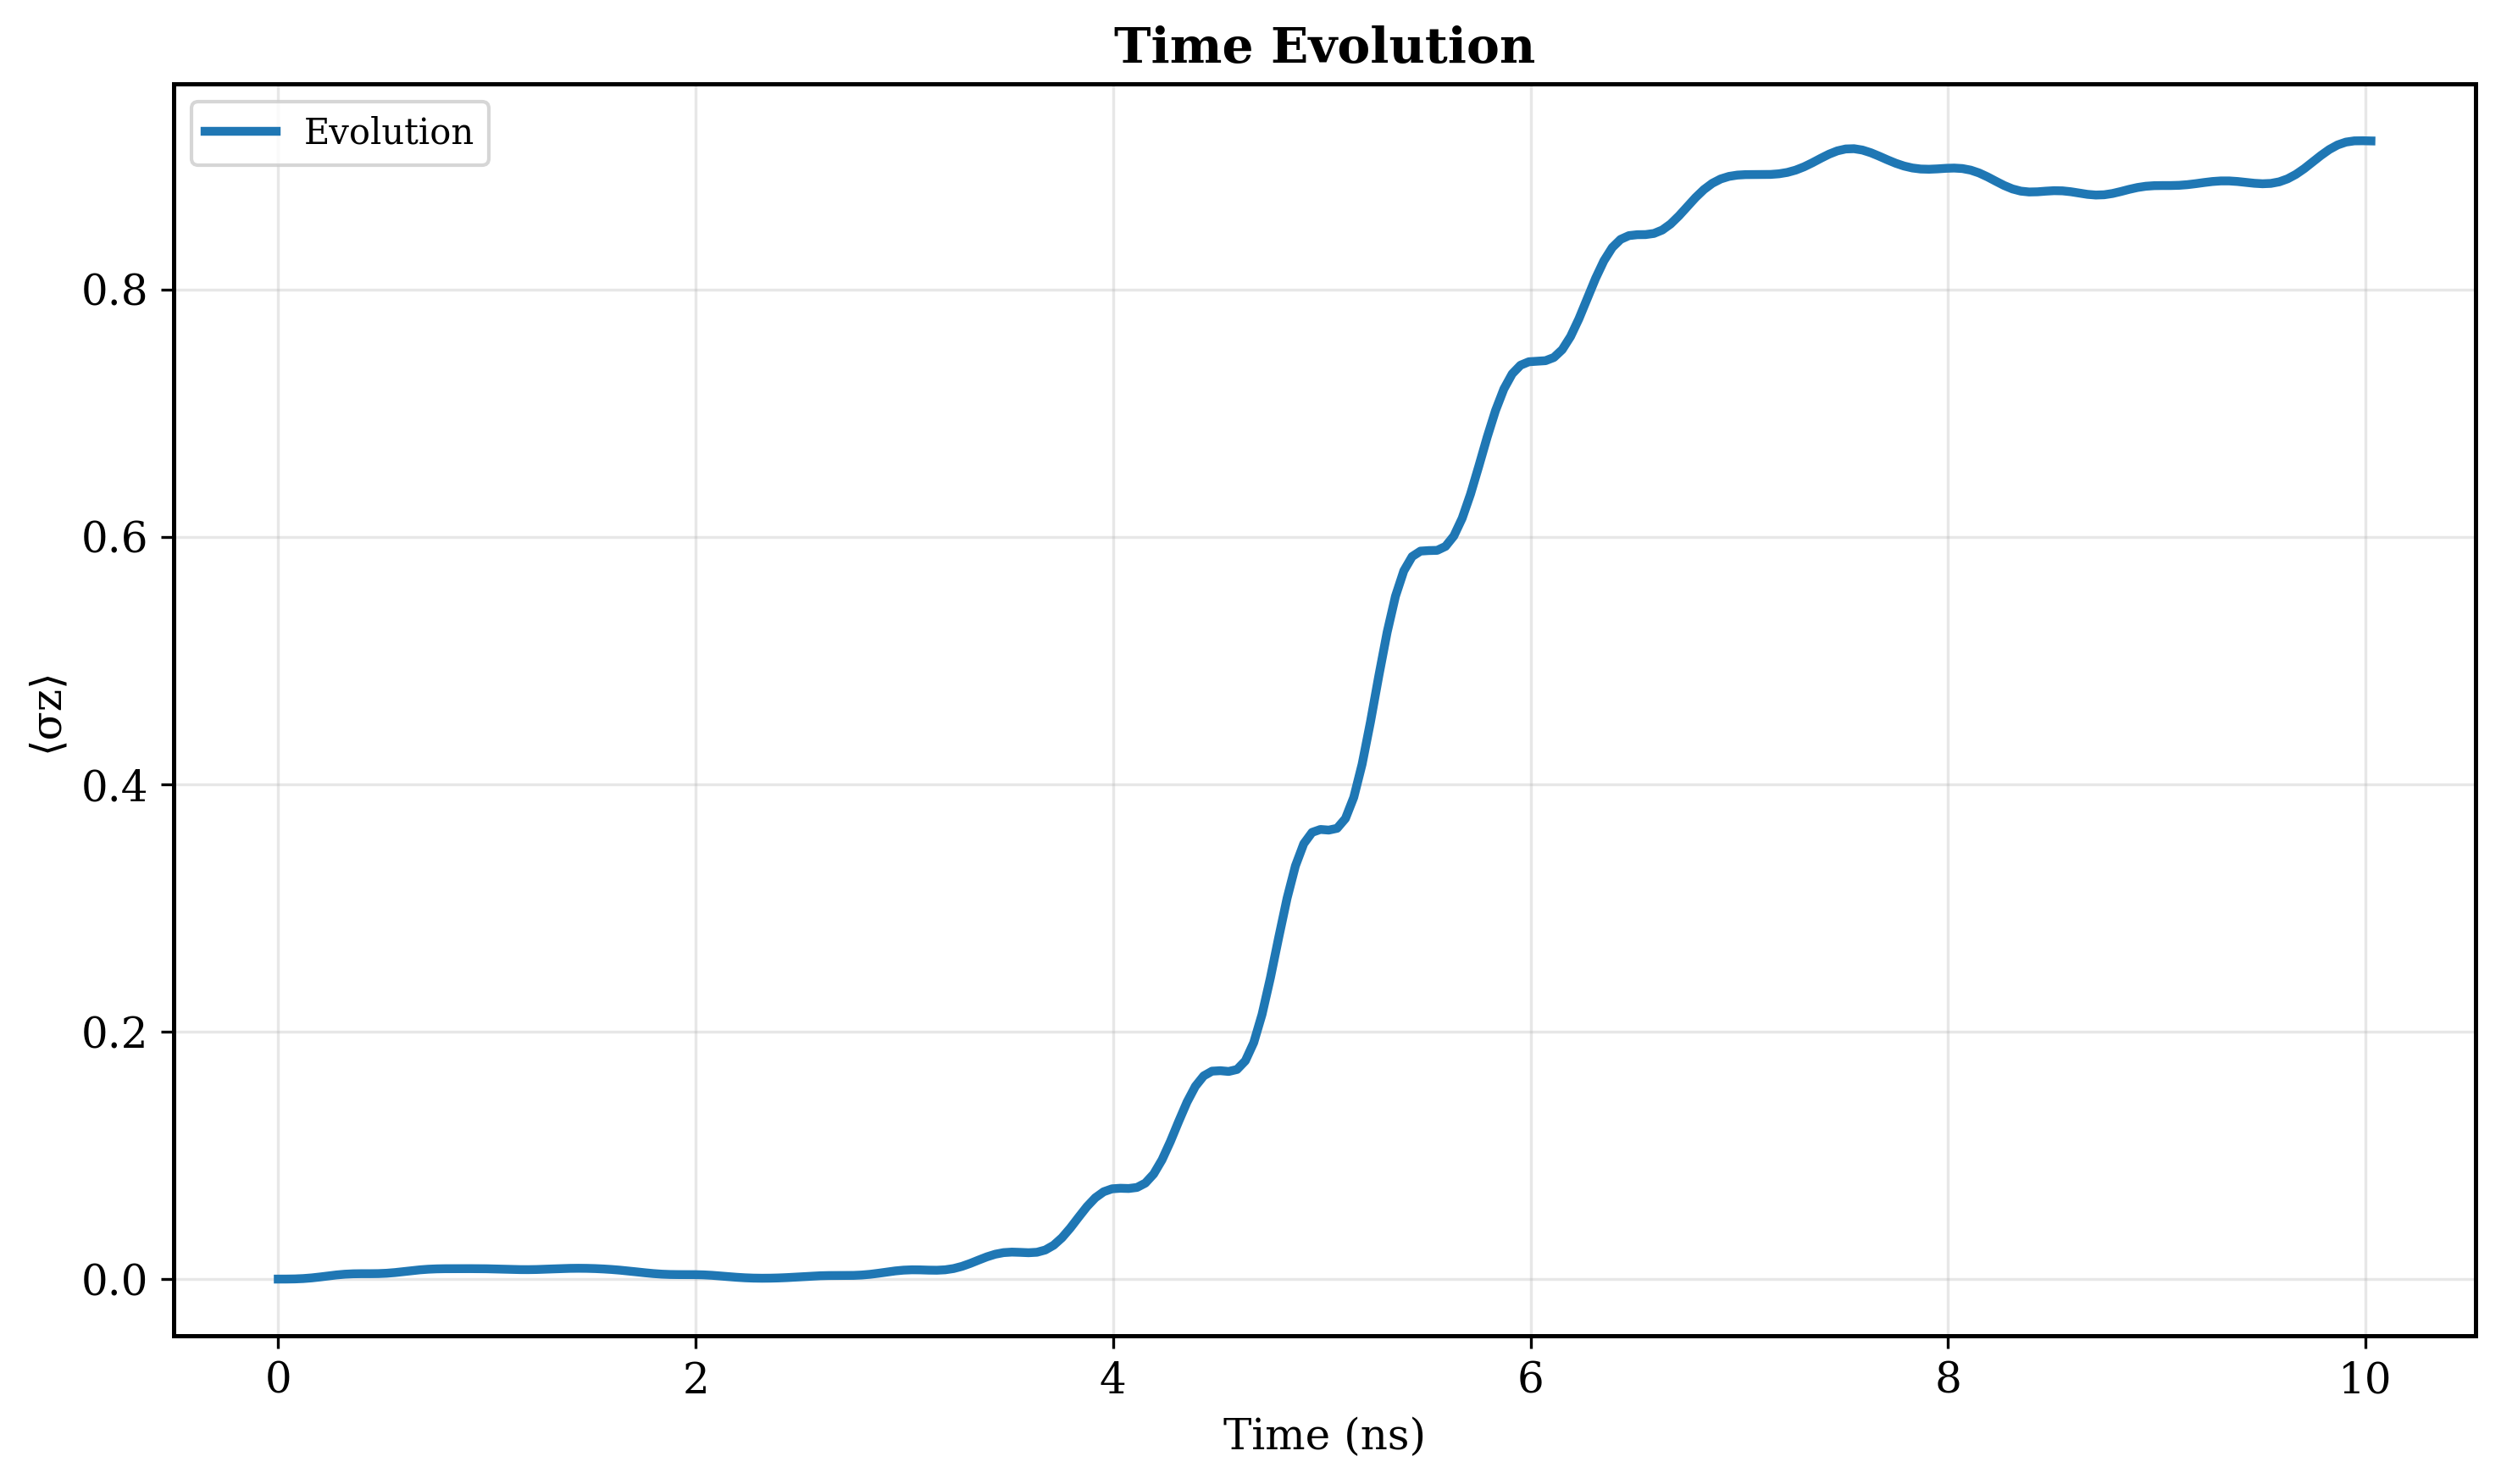

In [14]:
guess_result = simulate_controlled_evolution(
    time_array, initial_guess_y,
    time_array[-1],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)

plotter_guess = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

plotter_guess.plot_time_evolution(time_array,
                            guess_result['expect'][-1], ylabel='⟨σz⟩')


In [15]:
# Run Y gate optimization with Neural Network initial guess
start = time.time()
y_opt_res_NN = optimize_y_gate(
    fourier_modes=16, max_iterations=1,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=initial_guess_y
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
y_opt_sim_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res_NN['optimization_result'].x,
    drive_period=y_opt_res_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y_NN, ey_y_NN, ez_y_NN = extract_qubit_expectations(y_opt_sim_NN['states'])

# Store
y_opt_cost_NN = y_opt_res_NN['optimization_result'].fun
y_opt_fid_NN = 1 - y_opt_cost_NN
gate_results['y_gate_NN'] = {
    'result': y_opt_res_NN,
    'traj': (ex_y_NN, ey_y_NN, ez_y_NN),
    'cost': y_opt_cost_NN,
    'fidelity': y_opt_fid_NN,
    'nfev': y_opt_res_NN['nfev'],
    'time_elapsed': elapsed
}

print(f"Y_NN gate optimization complete: cost={y_opt_cost_NN:.3e}, fidelity={y_opt_fid_NN:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {y_opt_res_NN['nfev']}")

Starting optimization with provided initial guess...
Parameter space dimension: 32
Optimization method: L-BFGS-B
Variable bounds: (-0.32, 0.32)
------------------------------------------------------------
Cost = 1.227760e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.227760e-04
Optimization success: True
Function evaluations: 1188
Y_NN gate optimization complete: cost=1.228e-04, fidelity=0.9999, time=185.45s
Time elapsed: 185.45 seconds
Total function evaluations: 1188


In [6]:
y_opt_res_NN = np.load(f'data/payloads/y_gate/y_opt_res_NN.npz', allow_pickle=True)['y_opt_res_NN'].item()

# Simulate trajectory with optimal coefficients
y_opt_sim_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res_NN['optimization_result'].x,
    drive_period=y_opt_res_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y_NN, ey_y_NN, ez_y_NN = extract_qubit_expectations(y_opt_sim_NN['states'])

# Store
y_opt_cost_NN = y_opt_res_NN['optimization_result'].fun
y_opt_fid_NN = 1 - y_opt_cost_NN
gate_results['y_gate_NN'] = {
    'result': y_opt_res_NN,
    'traj': (ex_y_NN, ey_y_NN, ez_y_NN),
    'cost': y_opt_cost_NN,
    'fidelity': y_opt_fid_NN,
    'nfev': y_opt_res_NN['nfev'],
    'time_elapsed': 185.45
}

print(f"Y_NN gate optimization complete: cost={y_opt_cost_NN:.3e}, fidelity={y_opt_fid_NN:.4f}, time={185.45:.2f}s")
print(f"Time elapsed: {185.45:.2f} seconds")
print(f"Total function evaluations: {y_opt_res_NN['nfev']}")

Y_NN gate optimization complete: cost=1.228e-04, fidelity=0.9999, time=185.45s
Time elapsed: 185.45 seconds
Total function evaluations: 1188


Figure saved: results/y_gate_NN_bloch_components.png


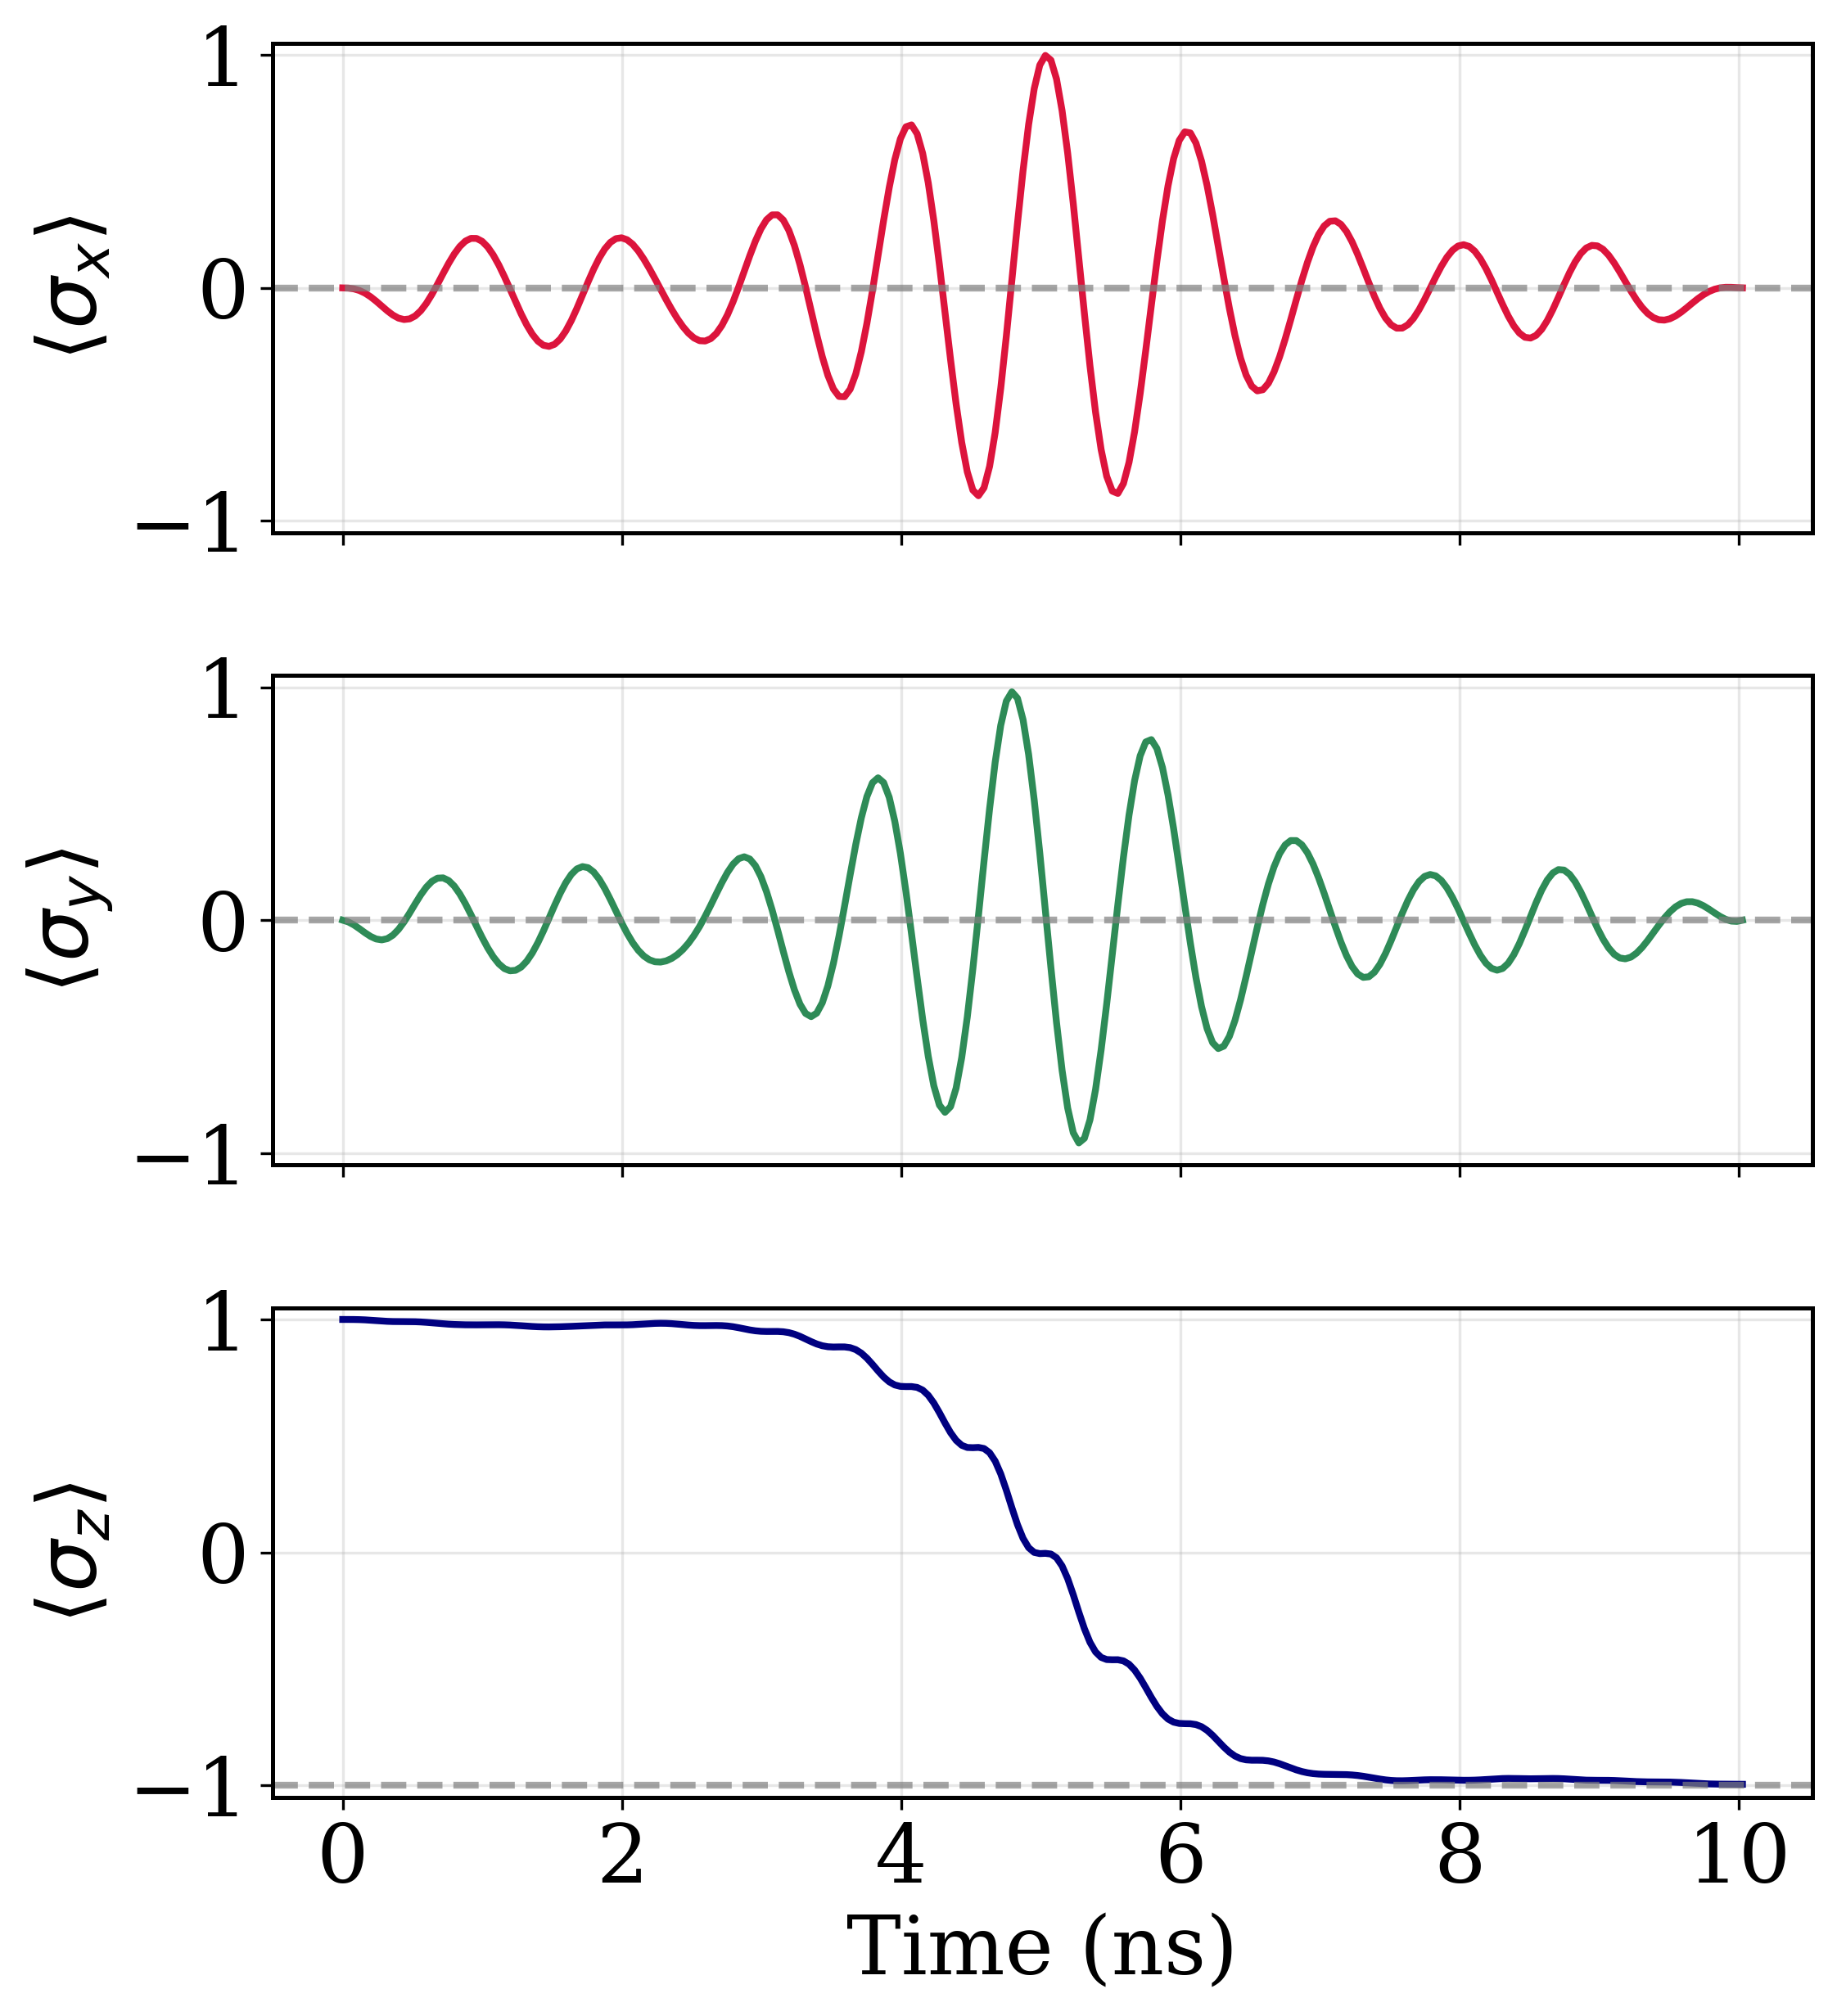

Figure saved: results/y_gate_NN_bloch_trajectory.png


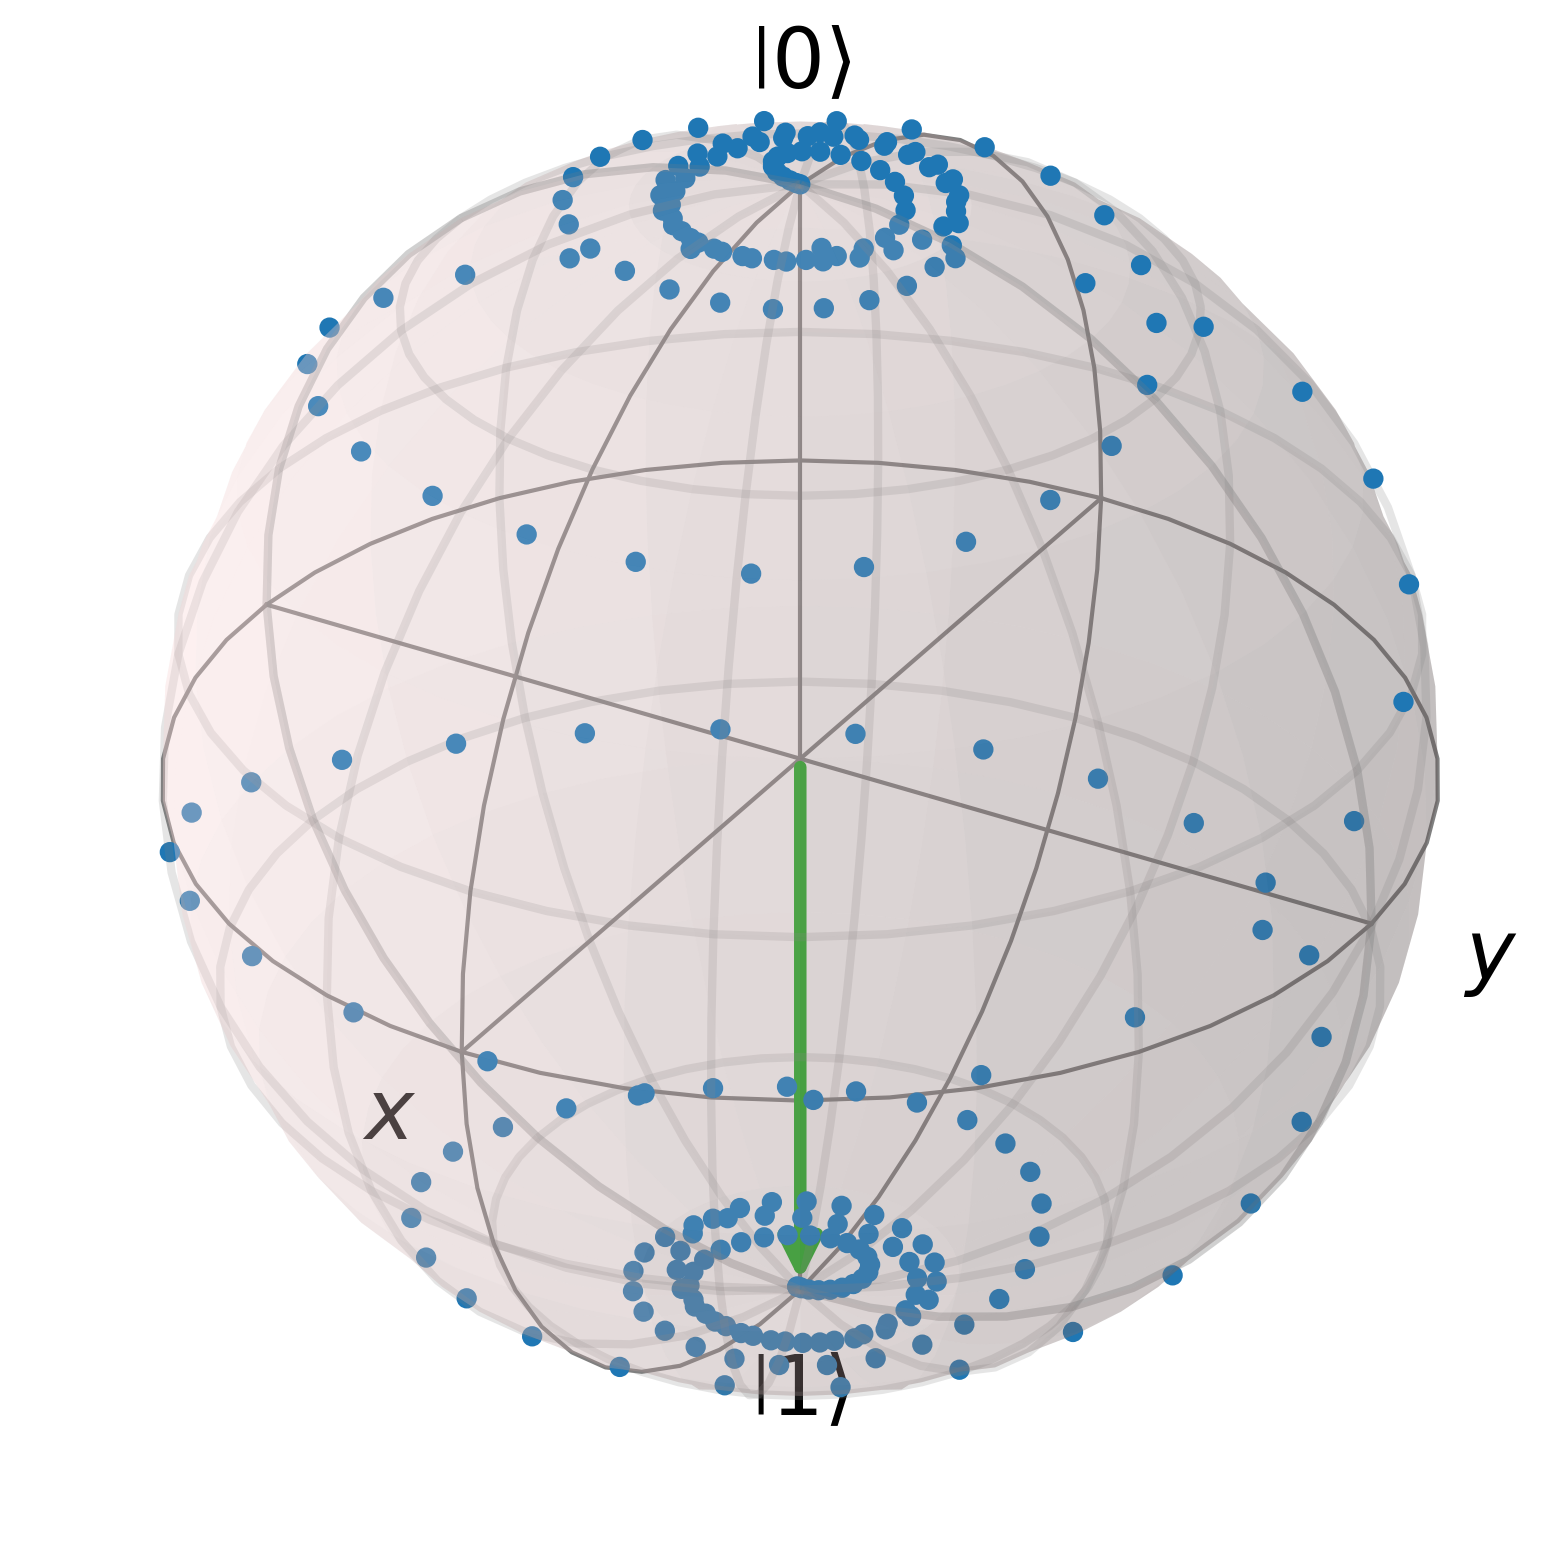

Figure saved: results/y_gate_NN_control_field_analysis.png


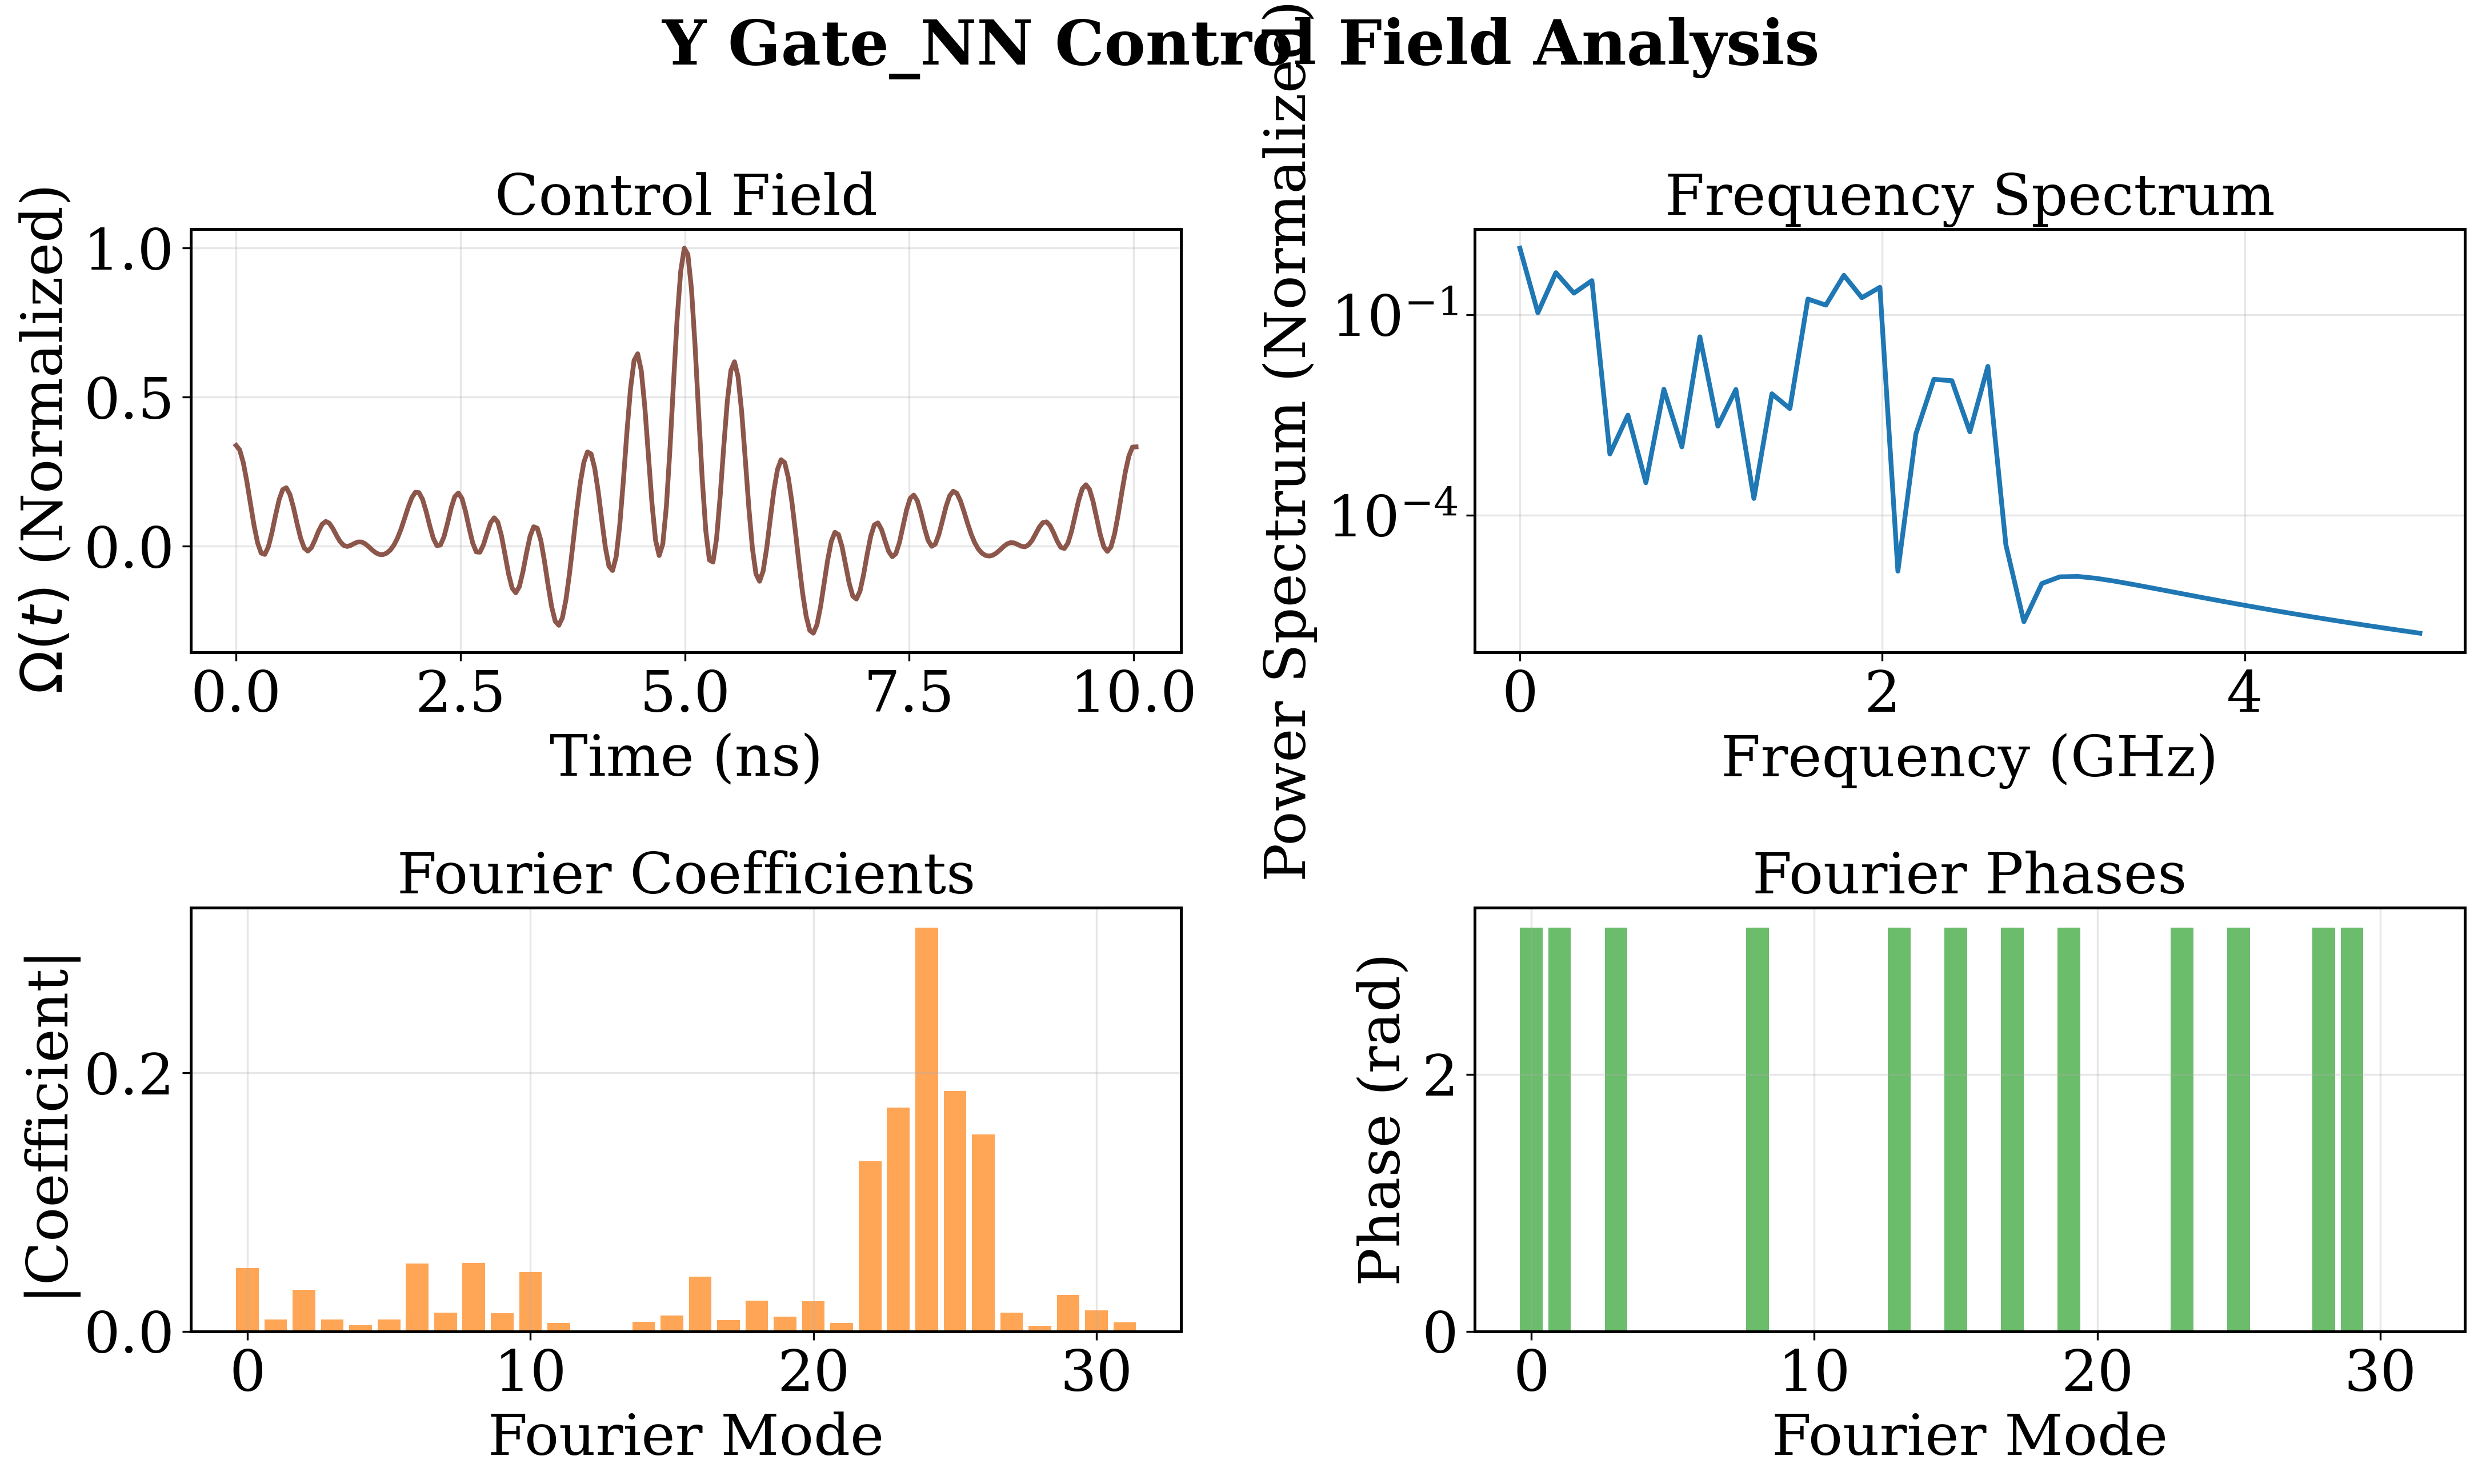

Y Gate_NN final Bloch vector: [0.00017092189992362126, 2.3106017514738726e-05, -0.9949496869644598]
Y Gate_NN ideal Bloch vector: [0.0, 0.0, -1.0]
Y Gate_NN Bloch vector error (L2): 0.0051
Y Gate_NN fidelity (stored): 0.9999


In [7]:
# Y Gate_NN: Refactored Plotting Using Plotting Module
y_opt_coeffs_NN = gate_results['y_gate_NN']['result']['optimization_result'].x
y_opt_period_NN = gate_results['y_gate_NN']['result']['control_period']
control_field_y_NN = compute_fourier_control_field(time_array, 
                                                   y_opt_coeffs_NN, 
                                                   y_opt_period_NN)
ex_y_NN, ey_y_NN, ez_y_NN = gate_results['y_gate_NN']['traj']
ideal_vec_y_NN = ideal_bloch['y_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_y_NN, ey_y_NN, ez_y_NN, 
                                   ideal_vector=ideal_vec_y_NN, gate_name='Y Gate_NN',
                                   filename='y_gate_NN_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_y_NN, ey_y_NN, ez_y_NN, 
                                   ideal_vector=ideal_vec_y_NN, gate_name='Y Gate_NN',
                                   filename='y_gate_NN_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_y_NN.real, 
                                         fourier_coefficients=y_opt_coeffs_NN, title='Y Gate_NN Control Field Analysis',
                                         filename='y_gate_NN_control_field_analysis.png')

final_vec_y_NN = [ex_y_NN[-1], ey_y_NN[-1], ez_y_NN[-1]]
err_y_NN = np.linalg.norm(np.array(final_vec_y_NN) - np.array(ideal_vec_y_NN))
print(f"Y Gate_NN final Bloch vector: {final_vec_y_NN}")
print(f"Y Gate_NN ideal Bloch vector: {ideal_vec_y_NN}")
print(f"Y Gate_NN Bloch vector error (L2): {err_y_NN:.4f}")
print(f"Y Gate_NN fidelity (stored): {gate_results['y_gate_NN']['fidelity']:.4f}")

In [20]:
# Run Y gate optimization - Nelder-Mead
start = time.time()
y_opt_res_nm = optimize_y_gate(
    fourier_modes=16, max_iterations=6,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=None, optimization_method='Nelder-Mead'
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
y_opt_sim_nm = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res_nm['optimization_result'].x,
    drive_period=y_opt_res_nm['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y_nm, ey_y_nm, ez_y_nm = extract_qubit_expectations(y_opt_sim_nm['states'])

# Store
y_opt_cost_nm = y_opt_res_nm['optimization_result'].fun
y_opt_fid_nm = 1 - y_opt_cost_nm
gate_results['y_gate_nm'] = {
    'result': y_opt_res_nm,
    'traj': (ex_y_nm, ey_y_nm, ez_y_nm),
    'cost': y_opt_cost_nm,
    'fidelity': y_opt_fid_nm,
    'time_elapsed': elapsed
}

print(f"Y gate optimization complete: cost={y_opt_cost_nm:.3e}, fidelity={y_opt_fid_nm:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {y_opt_res_nm['nfev']}")

Starting global optimization with 6 random initializations...
Parameter space dimension: 32
Optimization method: Nelder-Mead
Variable bounds: (-0.32, 0.32)
------------------------------------------------------------


/home/denysderlian/projects/tgRepo_qubitControl/src/optimization.py:128: OptimizeWarning: Initial guess is not within the specified bounds
  best_result = minimize(


Iteration 1: Parameters = 32, Cost = 1.279706e-04


/home/denysderlian/projects/tgRepo_qubitControl/src/optimization.py:142: OptimizeWarning: Initial guess is not within the specified bounds
  current_result = minimize(


Iteration 2: Parameters = 32, Cost = 1.226445e-04
  → New best solution found!
Iteration 3: Parameters = 32, Cost = 1.266053e-04
Iteration 4: Parameters = 32, Cost = 1.284912e-04
Iteration 5: Parameters = 32, Cost = 1.230485e-04
Iteration 6: Parameters = 32, Cost = 1.518217e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.226445e-04
Optimization success: True
Function evaluations: 2723
Y gate optimization complete: cost=1.226e-04, fidelity=0.9999, time=5116.80s
Time elapsed: 5116.80 seconds
Total function evaluations: 32179


In [8]:
y_opt_res_nm = np.load(f'data/payloads/y_gate/y_opt_res_nm.npz', allow_pickle=True)['y_opt_res_nm'].item()
# Simulate trajectory with optimal coefficients
y_opt_sim_nm = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res_nm['optimization_result'].x,
    drive_period=y_opt_res_nm['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y_nm, ey_y_nm, ez_y_nm = extract_qubit_expectations(y_opt_sim_nm['states'])

# Store
y_opt_cost_nm = y_opt_res_nm['optimization_result'].fun
y_opt_fid_nm = 1 - y_opt_cost_nm
gate_results['y_gate_nm'] = {
    'result': y_opt_res_nm,
    'traj': (ex_y_nm, ey_y_nm, ez_y_nm),
    'cost': y_opt_cost_nm,
    'fidelity': y_opt_fid_nm,
    'time_elapsed': 5116.80
}

print(f"Y gate optimization complete: cost={y_opt_cost_nm:.3e}, fidelity={y_opt_fid_nm:.4f}, time={5116.80:.2f}s")
print(f"Time elapsed: {5116.80:.2f} seconds")
print(f"Total function evaluations: {y_opt_res_nm['nfev']}")

Y gate optimization complete: cost=1.226e-04, fidelity=0.9999, time=5116.80s
Time elapsed: 5116.80 seconds
Total function evaluations: 32179


Figure saved: results/y_gate_nm_bloch_components.png


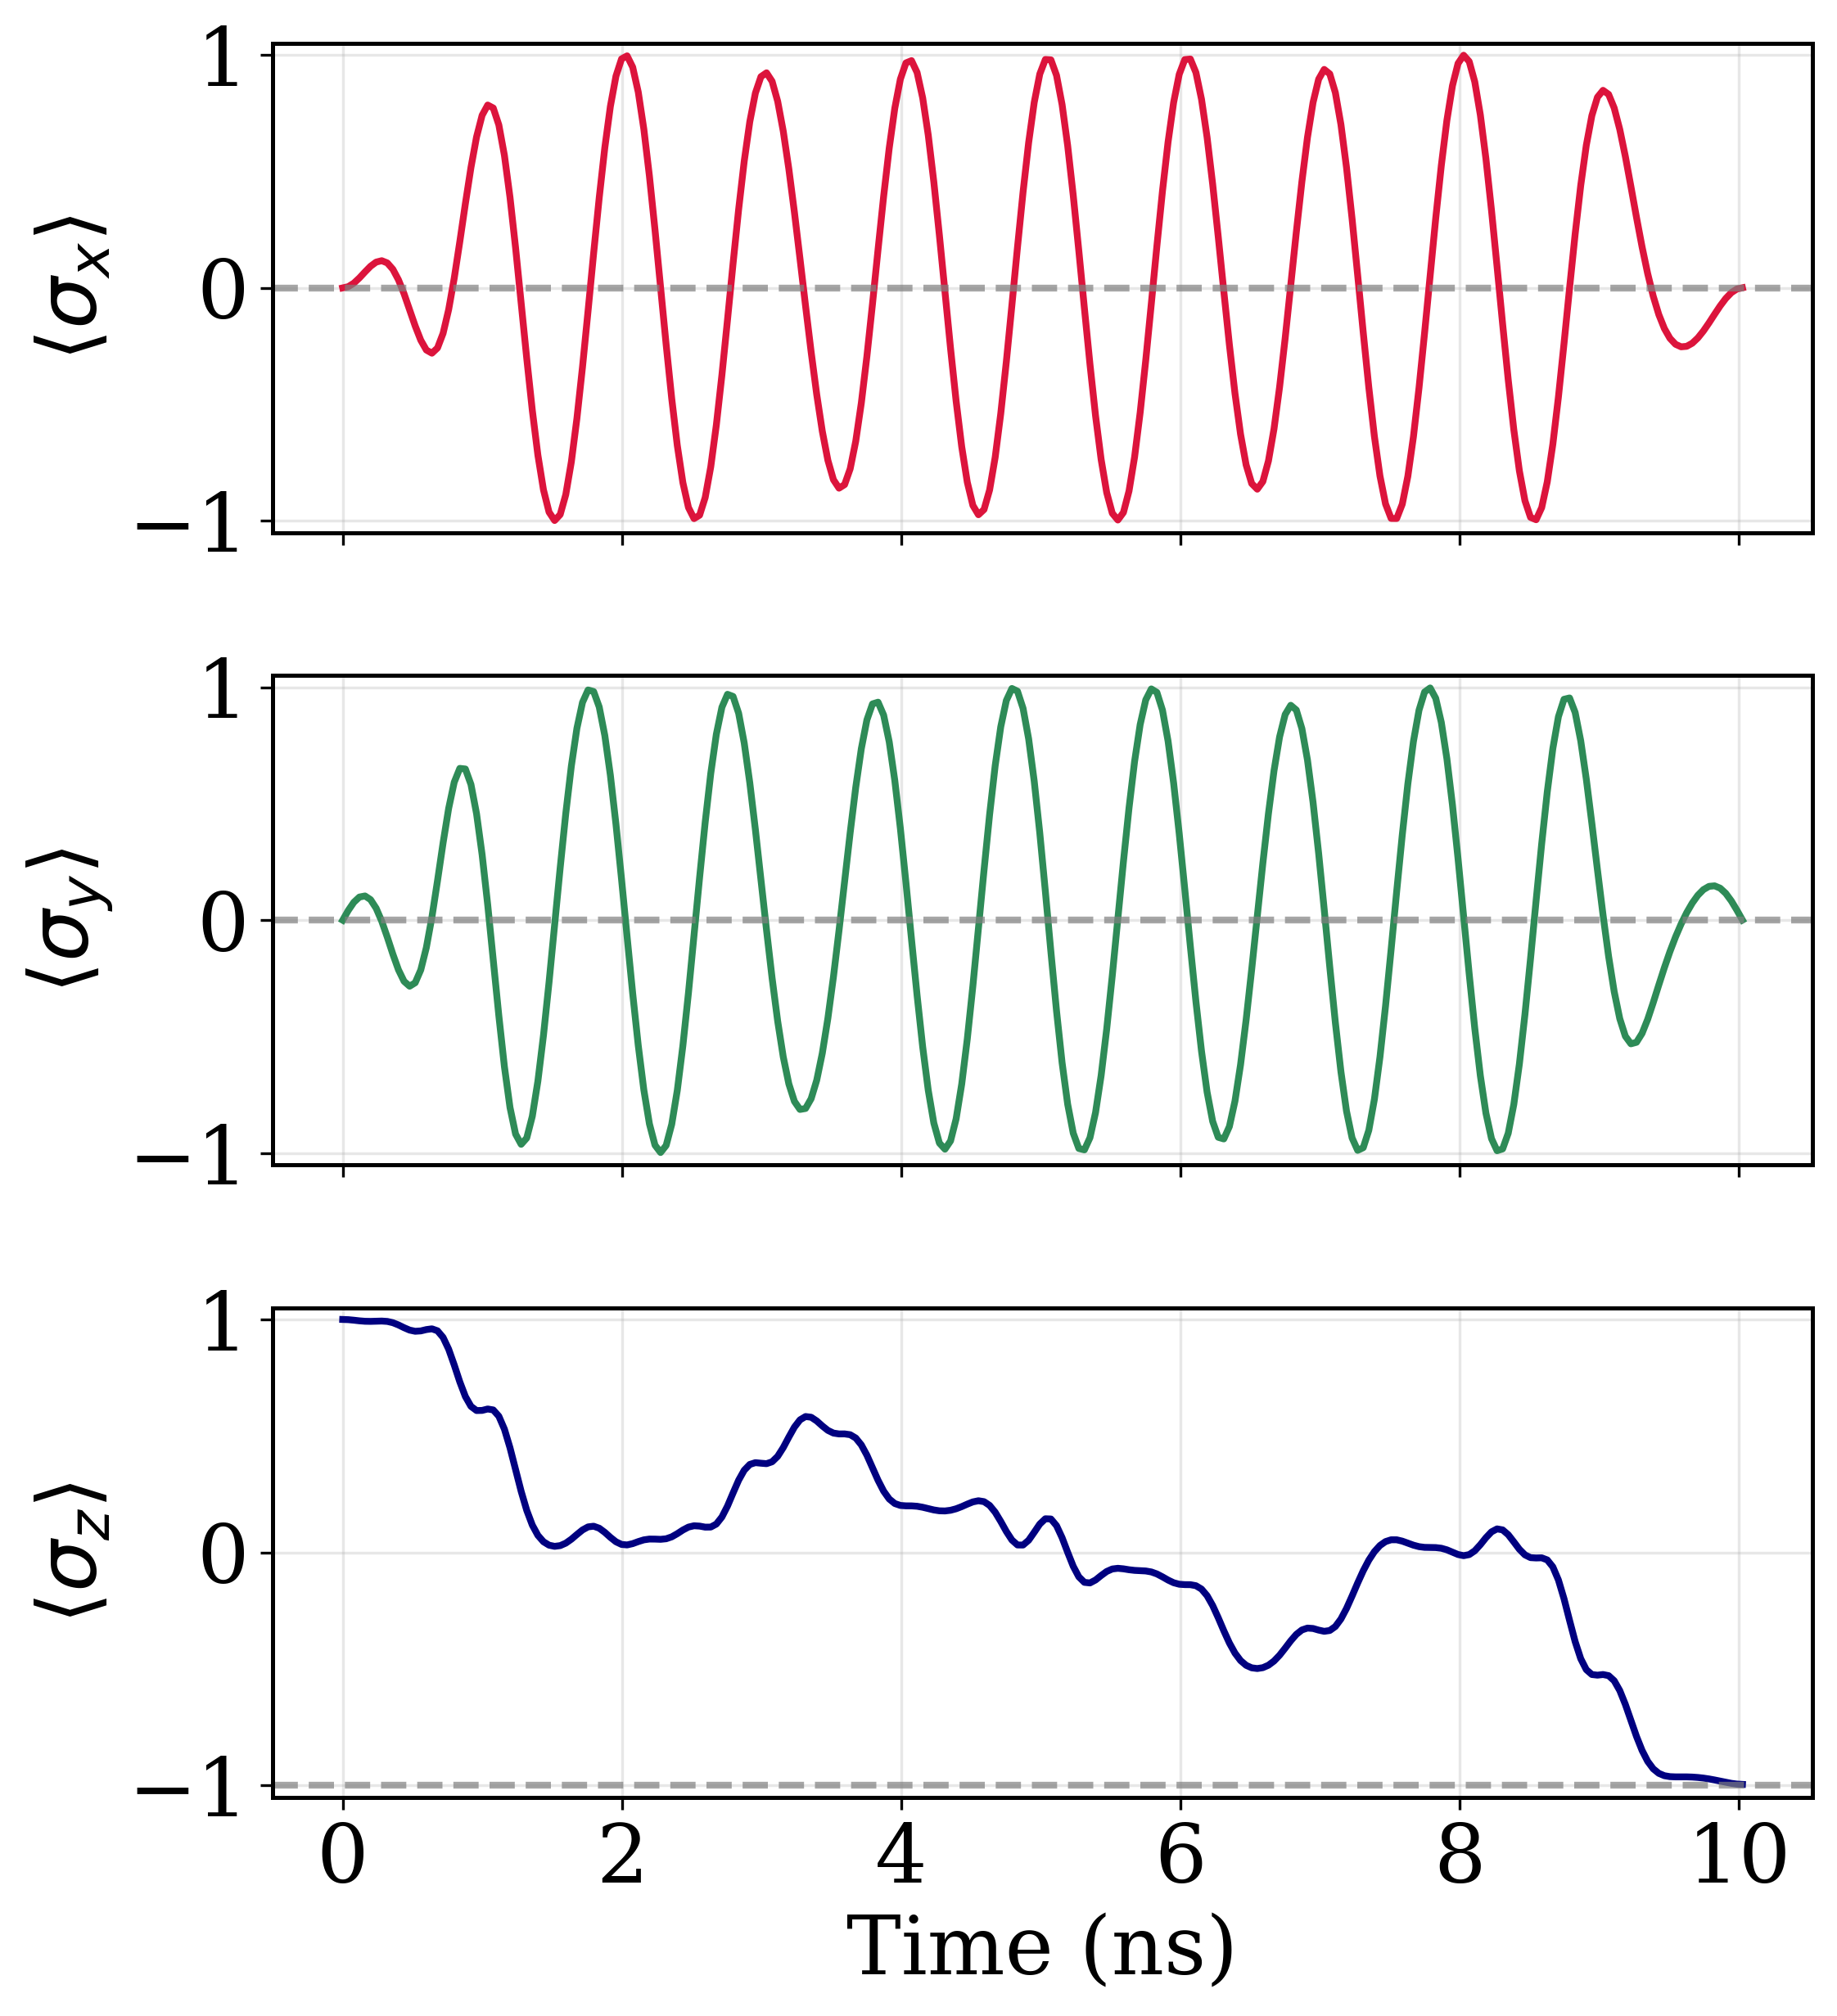

Figure saved: results/y_gate_nm_bloch_trajectory.png


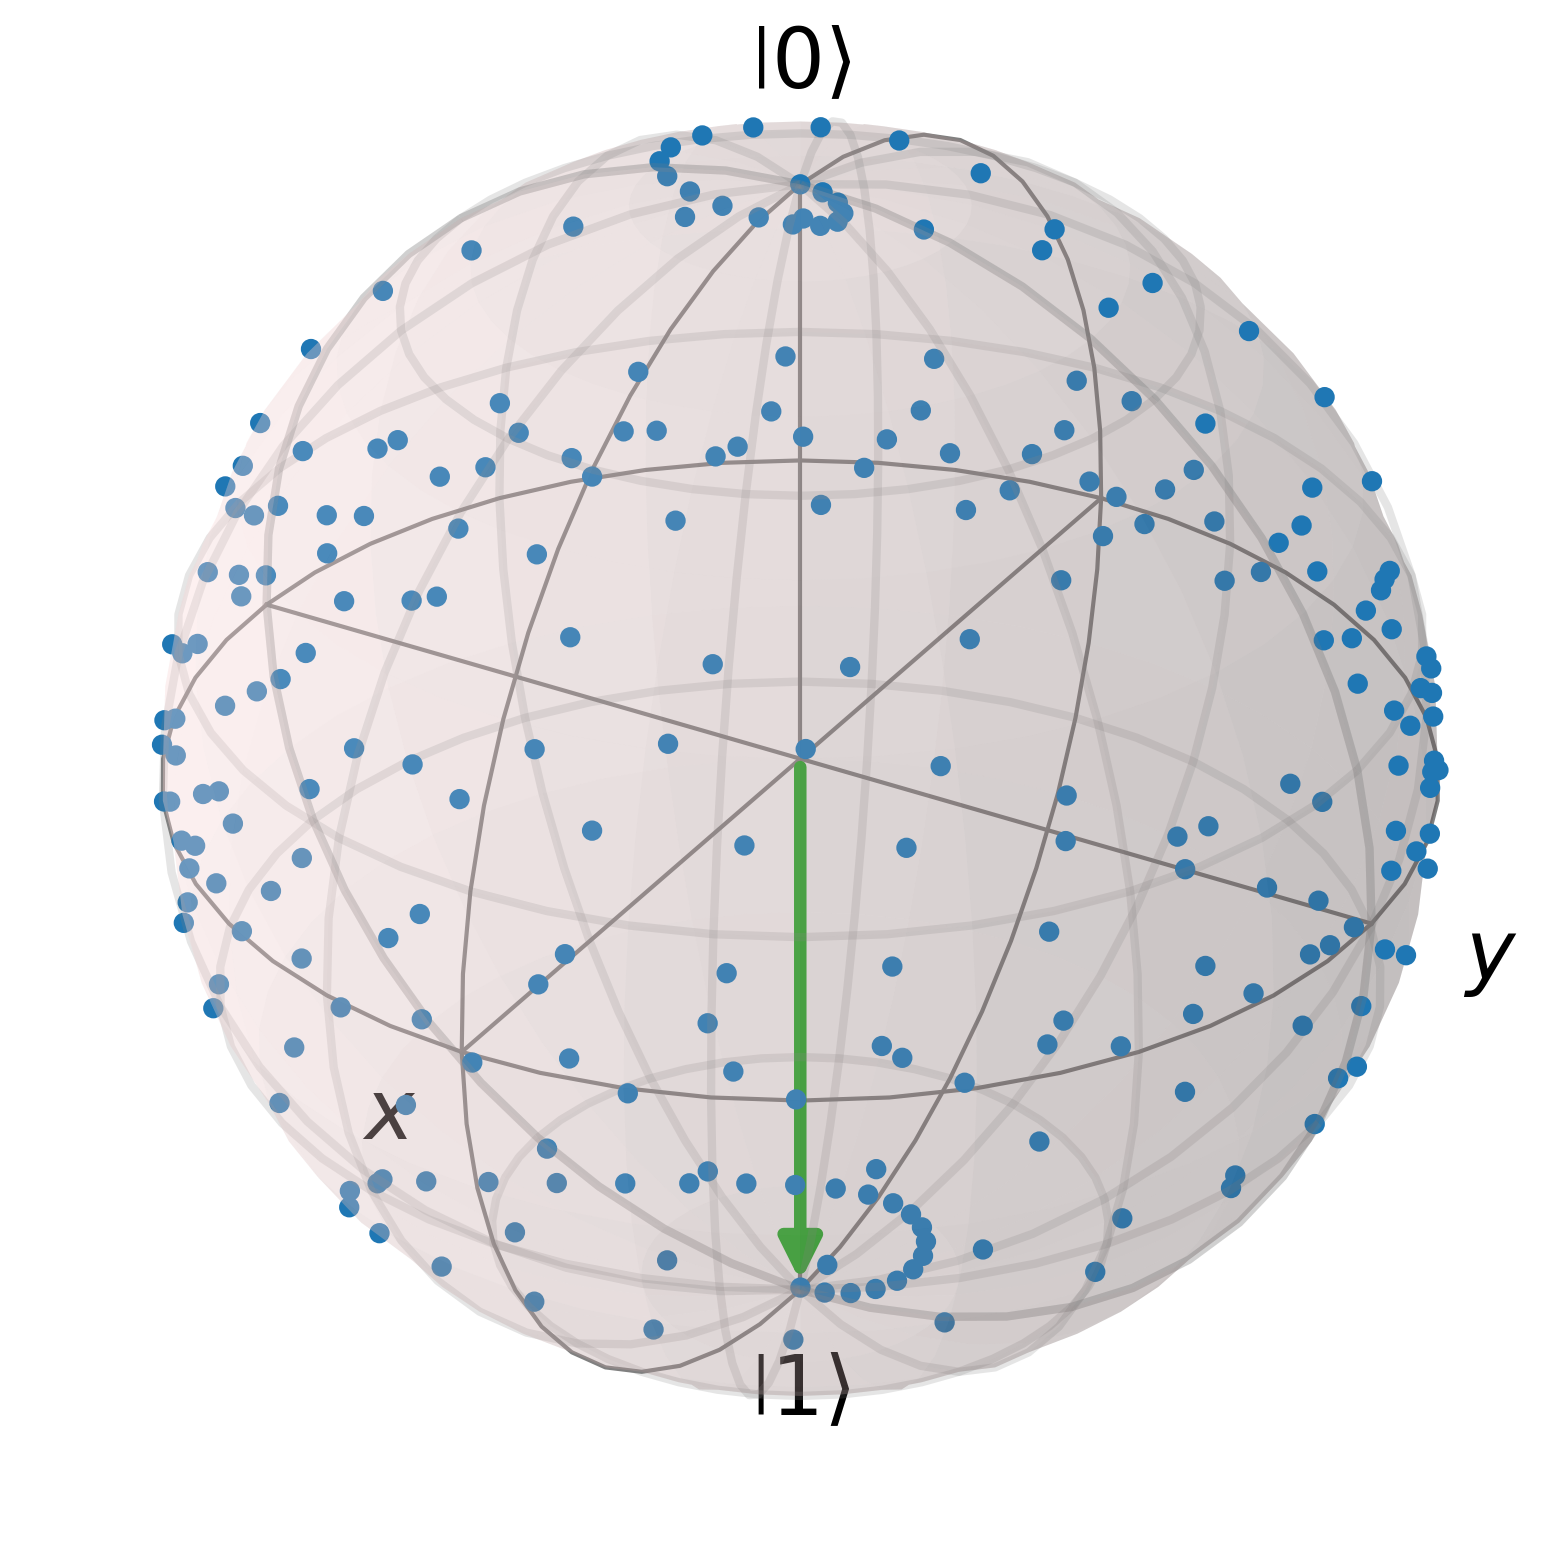

Figure saved: results/y_gate_nm_control_field_analysis.png


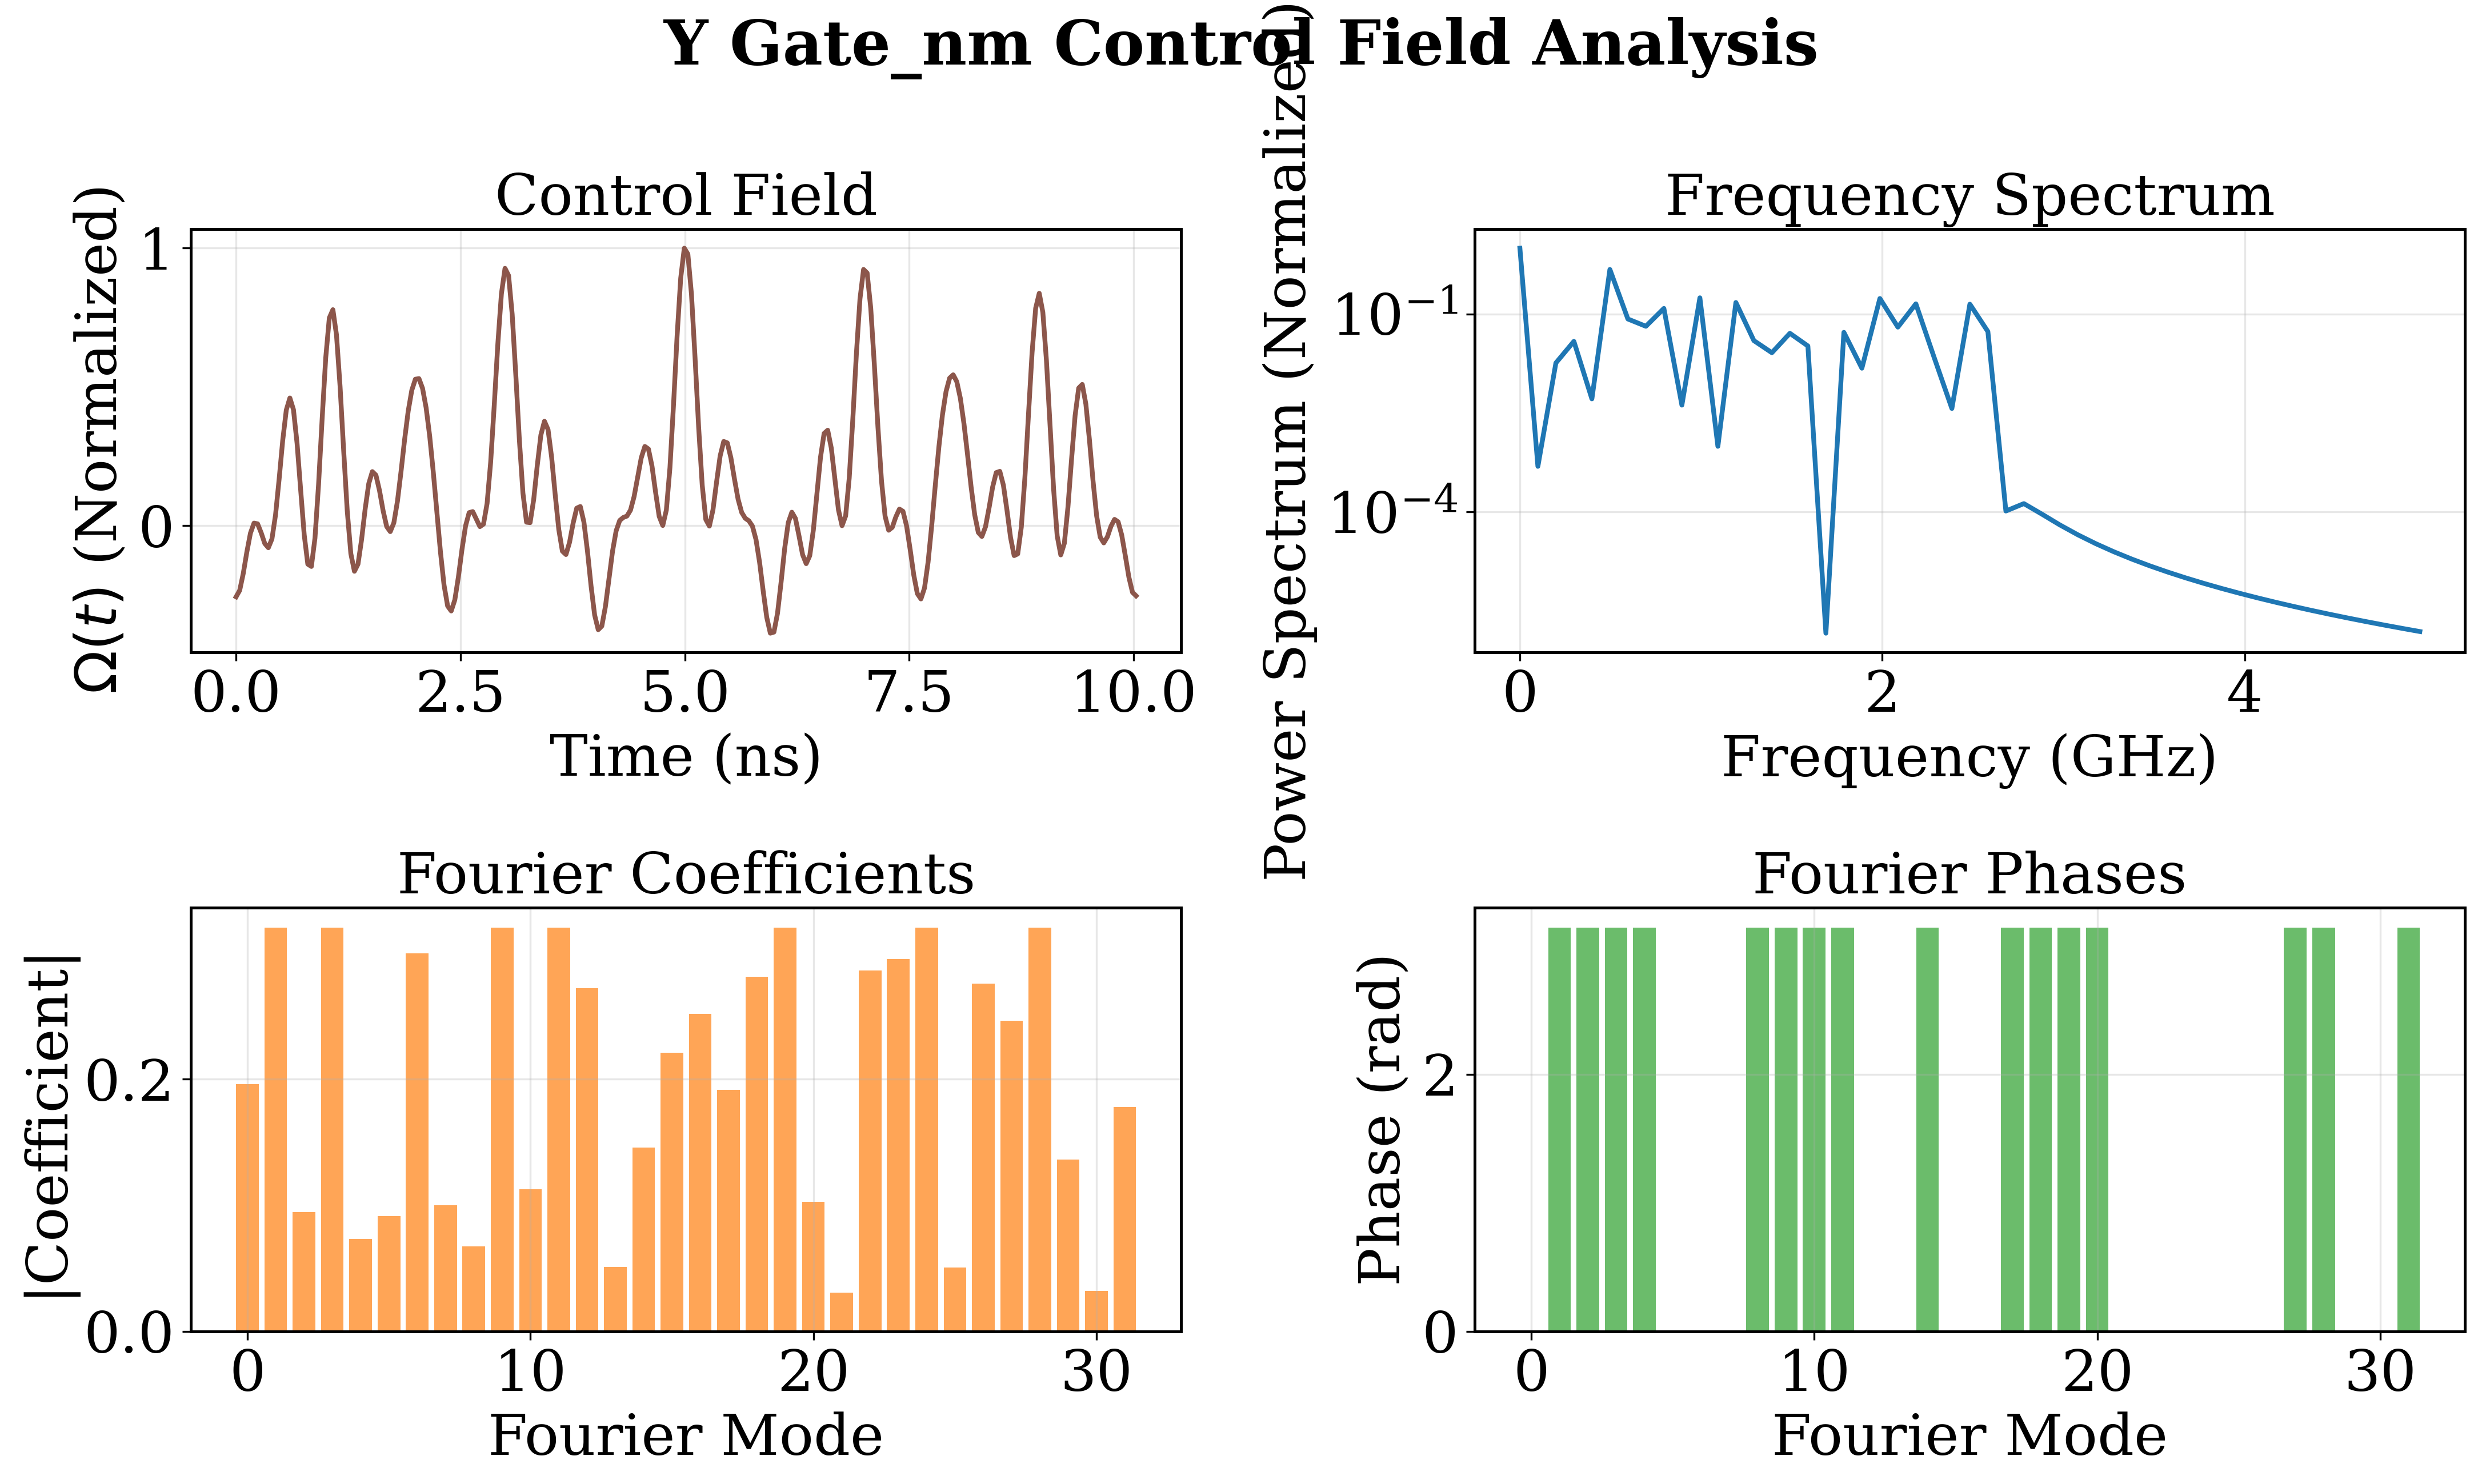

Y Gate_nm final Bloch vector: [0.00048535299773246553, 0.000551730382754882, -0.995363540688827]
Y Gate_nm ideal Bloch vector: [0.0, 0.0, -1.0]
Y Gate_nm Bloch vector error (L2): 0.0047
Y Gate_nm fidelity (stored): 0.9999


In [11]:
# Y_nm Gate: Refactored Plotting Using Plotting Module
y_opt_coeffs_nm = gate_results['y_gate_nm']['result']['optimization_result'].x
y_opt_period_nm = gate_results['y_gate_nm']['result']['control_period']
control_field_y_nm = compute_fourier_control_field(time_array, 
                                                   y_opt_coeffs_nm, 
                                                   y_opt_period_nm)
ex_y_nm, ey_y_nm, ez_y_nm = gate_results['y_gate_nm']['traj']
ideal_vec_y_nm = ideal_bloch['y_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_y_nm, ey_y_nm, ez_y_nm, 
                                   ideal_vector=ideal_vec_y_nm, gate_name='Y Gate_nm',
                                   filename='y_gate_nm_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_y_nm, ey_y_nm, ez_y_nm, ideal_vector=ideal_vec_y_nm, gate_name='Y Gate_nm',
                                   filename='y_gate_nm_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_y_nm.real, 
                                         fourier_coefficients=y_opt_coeffs_nm, title='Y Gate_nm Control Field Analysis',
                                         filename='y_gate_nm_control_field_analysis.png')

final_vec_y_nm = [ex_y_nm[-1], ey_y_nm[-1], ez_y_nm[-1]]
err_y_nm = np.linalg.norm(np.array(final_vec_y_nm) - np.array(ideal_vec_y_nm))
print(f"Y Gate_nm final Bloch vector: {final_vec_y_nm}")
print(f"Y Gate_nm ideal Bloch vector: {ideal_vec_y_nm}")
print(f"Y Gate_nm Bloch vector error (L2): {err_y_nm:.4f}")
print(f"Y Gate_nm fidelity (stored): {gate_results['y_gate_nm']['fidelity']:.4f}")

In [24]:
# Run Y_nm_NN gate optimization with Neural Network initial guess - Nelder-Mead method
start = time.time()
y_opt_res_nm_NN = optimize_y_gate(
    fourier_modes=16, max_iterations=1,
    coefficient_bounds=(-0.320,0.320), leakage_weight=0.05,
    system_params=system_params, collapse_ops=collapse_ops,
    initial_guess=initial_guess_y, optimization_method='Nelder-Mead'
)
elapsed = time.time() - start

# Simulate trajectory with optimal coefficients
y_opt_sim_nm_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res_nm_NN['optimization_result'].x,
    drive_period=y_opt_res_nm_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN = extract_qubit_expectations(y_opt_sim_nm_NN['states'])

# Store
y_opt_cost_nm_NN = y_opt_res_nm_NN['optimization_result'].fun
y_opt_fid_nm_NN = 1 - y_opt_cost_nm_NN
gate_results['y_gate_nm_NN'] = {
    'result': y_opt_res_nm_NN,
    'traj': (ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN),
    'cost': y_opt_cost_nm_NN,
    'fidelity': y_opt_fid_nm_NN,
    'nfev': y_opt_res_nm_NN['nfev'],
    'time_elapsed': elapsed
}

print(f"Y_nm_NN gate optimization complete: cost={y_opt_cost_nm_NN:.3e}, fidelity={y_opt_fid_nm_NN:.4f}, time={elapsed:.2f}s")
print(f"Time elapsed: {elapsed:.2f} seconds")
print(f"Total function evaluations: {y_opt_res_nm_NN['nfev']}")

Starting optimization with provided initial guess...
Parameter space dimension: 32
Optimization method: Nelder-Mead
Variable bounds: (-0.32, 0.32)
------------------------------------------------------------
Cost = 1.229446e-04
------------------------------------------------------------
Optimization completed. Best cost: 1.229446e-04
Optimization success: True
Function evaluations: 1346
Y_nm_NN gate optimization complete: cost=1.229e-04, fidelity=0.9999, time=215.04s
Time elapsed: 215.04 seconds
Total function evaluations: 1346


In [10]:
y_opt_res_nm_NN = np.load(f'data/payloads/y_gate/y_opt_res_nm_NN.npz', allow_pickle=True)['y_opt_res_nm_NN'].item()
# Simulate trajectory with optimal coefficients
y_opt_sim_nm_NN = simulate_controlled_evolution(
    time_array,
    fourier_coefficients=y_opt_res_nm_NN['optimization_result'].x,
    drive_period=y_opt_res_nm_NN['control_period'],
    system_params=system_params,
    initial_state=initial_state,
    collapse_ops=collapse_ops
)
ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN = extract_qubit_expectations(y_opt_sim_nm_NN['states'])

# Store
y_opt_cost_nm_NN = y_opt_res_nm_NN['optimization_result'].fun
y_opt_fid_nm_NN = 1 - y_opt_cost_nm_NN
gate_results['y_gate_nm_NN'] = {
    'result': y_opt_res_nm_NN,
    'traj': (ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN),
    'cost': y_opt_cost_nm_NN,
    'fidelity': y_opt_fid_nm_NN,
    'nfev': y_opt_res_nm_NN['nfev'],
    'time_elapsed': 215.04
}

print(f"Y_nm_NN gate optimization complete: cost={y_opt_cost_nm_NN:.3e}, fidelity={y_opt_fid_nm_NN:.4f}, time={215.04:.2f}s")
print(f"Time elapsed: {215.04:.2f} seconds")
print(f"Total function evaluations: {y_opt_res_nm_NN['nfev']}")

Y_nm_NN gate optimization complete: cost=1.229e-04, fidelity=0.9999, time=215.04s
Time elapsed: 215.04 seconds
Total function evaluations: 1346


Figure saved: results/y_gate_nm_NN_bloch_components.png


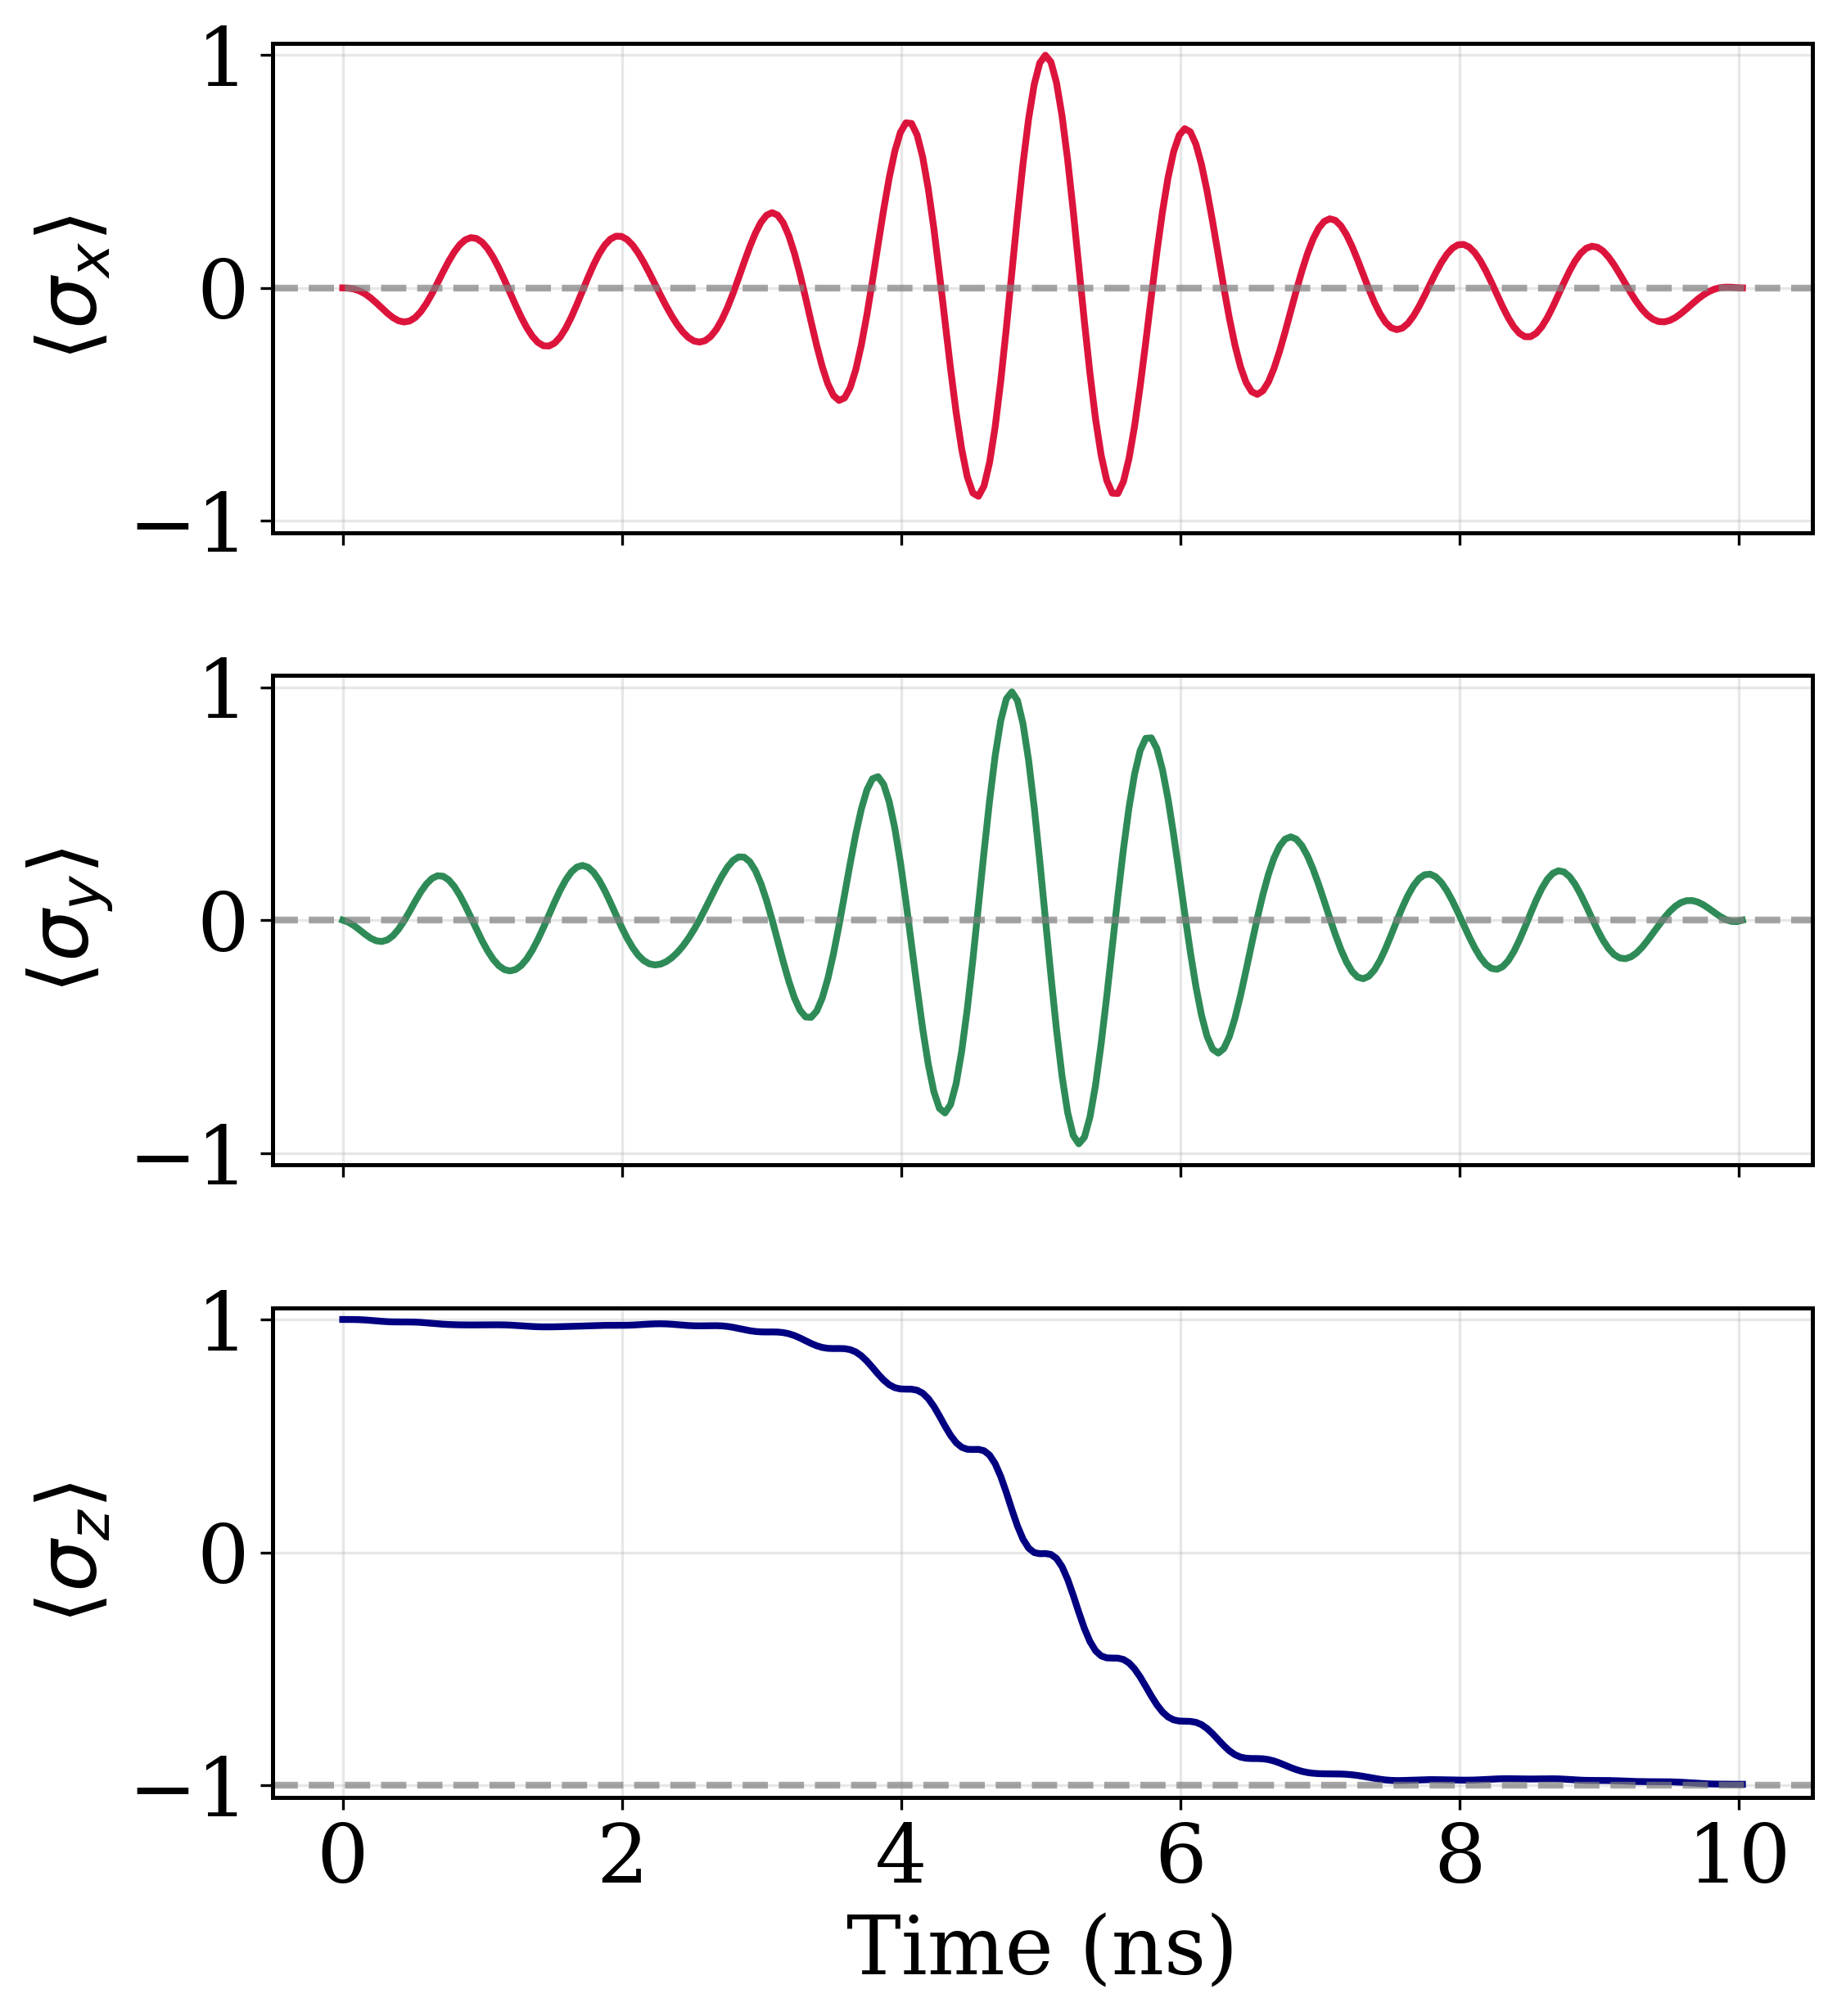

Figure saved: results/y_gate_nm_NN_bloch_trajectory.png


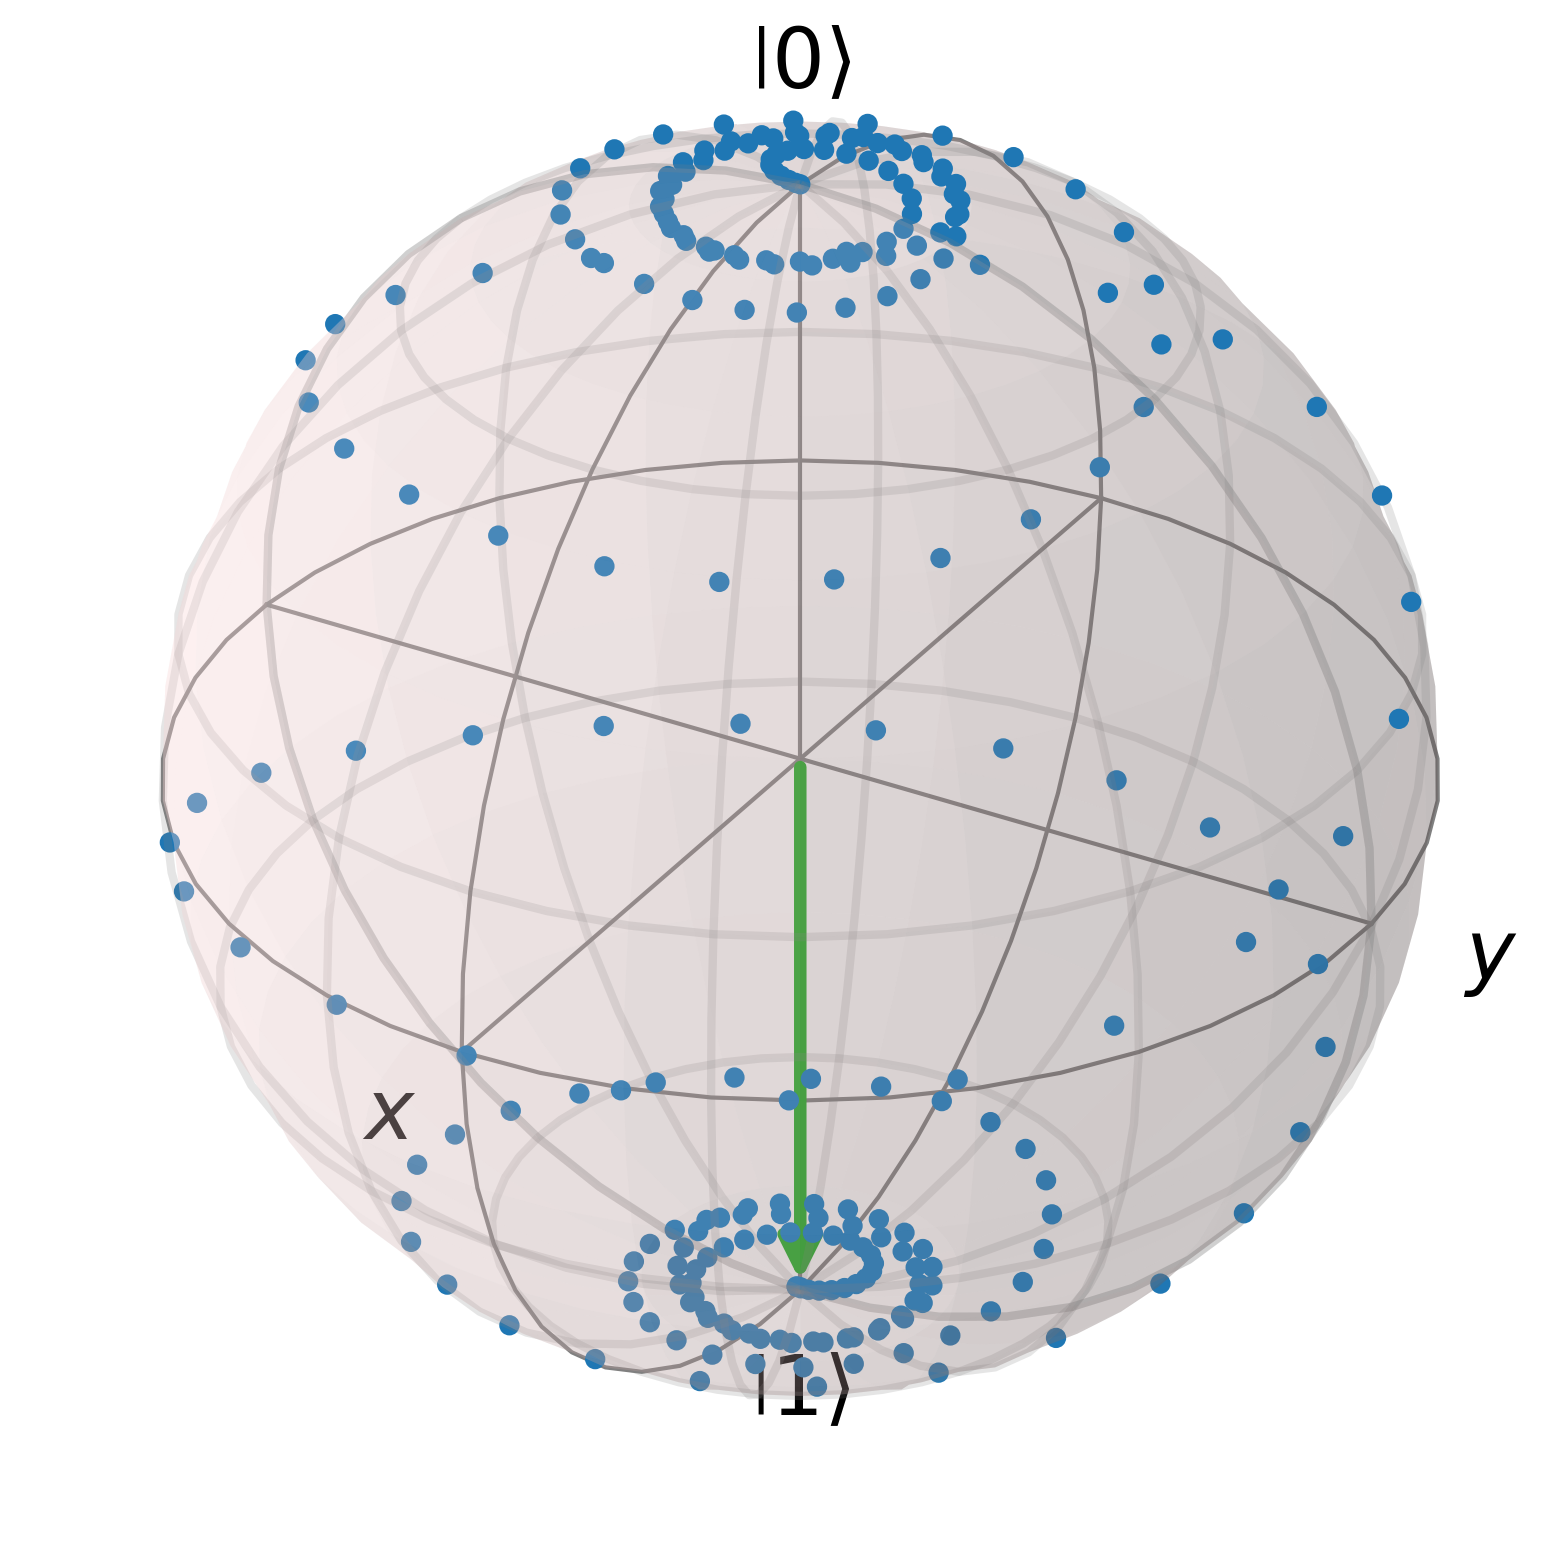

Figure saved: results/y_gate_nm_NN_control_field_analysis.png


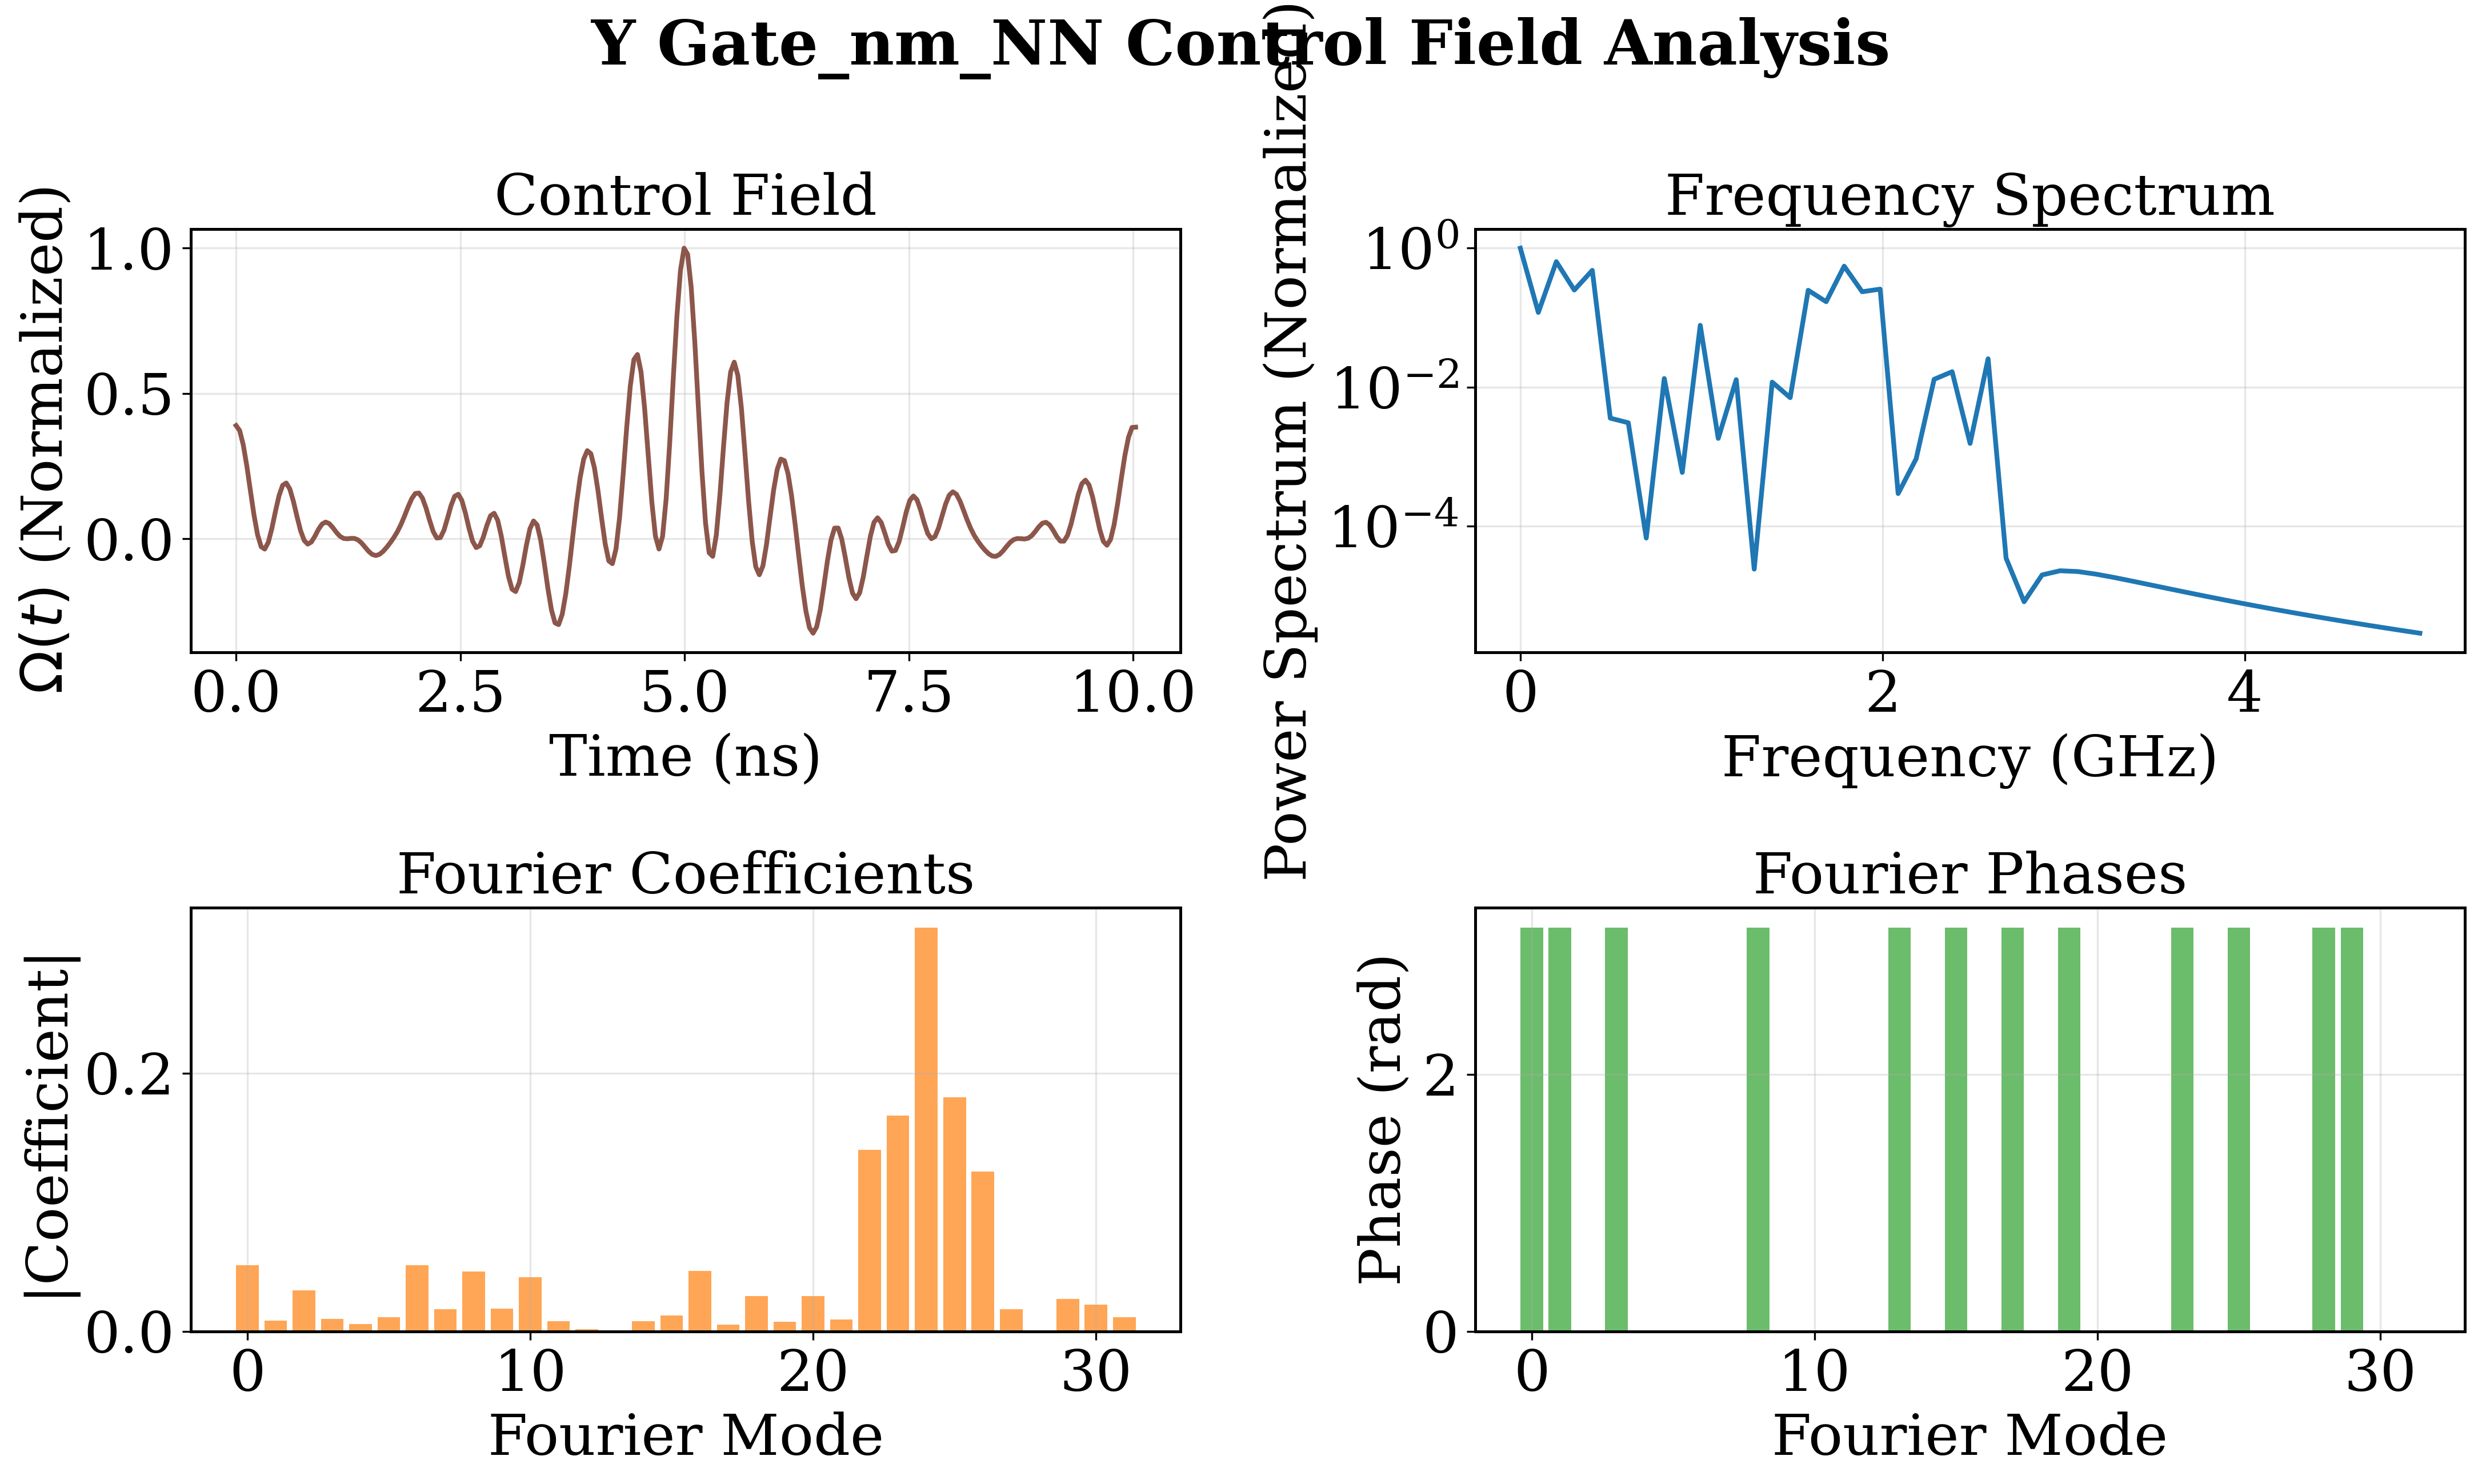

Y Gate_nm_NN final Bloch vector: [0.00016470816837239538, 2.3357074323571413e-05, -0.9949493517422525]
Y Gate_nm_NN ideal Bloch vector: [0.0, 0.0, -1.0]
Y Gate_nm_NN Bloch vector error (L2): 0.0051
Y Gate_nm_NN fidelity (stored): 0.9999


In [12]:
# Y Gate_nm_NN: Refactored Plotting Using Plotting Module
y_opt_coeffs_nm_NN = gate_results['y_gate_nm_NN']['result']['optimization_result'].x
y_opt_period_nm_NN = gate_results['y_gate_nm_NN']['result']['control_period']
control_field_y_nm_NN = compute_fourier_control_field(time_array, 
                                                   y_opt_coeffs_nm_NN, 
                                                   y_opt_period_nm_NN)
ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN = gate_results['y_gate_nm_NN']['traj']
ideal_vec_y_nm_NN = ideal_bloch['y_gate']  # Ideal Bloch vector

# Initialize plotter (reuse existing global plotter if defined)
try:
    gate_plotter = plotter
except NameError:
    gate_plotter = QuantumControlPlotter(show_plots=True, use_latex=False, figure_format='png')

# Plot Bloch components
gate_plotter.plot_bloch_components(time_array, ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN, 
                                   ideal_vector=ideal_vec_y_nm_NN, gate_name='Y Gate_nm_NN',
                                   filename='y_gate_nm_NN_bloch_components.png')
# Plot Bloch trajectory
gate_plotter.plot_bloch_trajectory(ex_y_nm_NN, ey_y_nm_NN, ez_y_nm_NN, ideal_vector=ideal_vec_y_nm_NN, 
                                   gate_name='Y Gate_nm_NN',
                                   filename='y_gate_nm_NN_bloch_trajectory.png')
# Plot control field analysis
gate_plotter.plot_control_field_analysis(time_array, control_field_y_nm_NN.real, 
                                         fourier_coefficients=y_opt_coeffs_nm_NN, title='Y Gate_nm_NN Control Field Analysis',
                                         filename='y_gate_nm_NN_control_field_analysis.png')

final_vec_y_nm_NN = [ex_y_nm_NN[-1], ey_y_nm_NN[-1], ez_y_nm_NN[-1]]
err_y_nm_NN = np.linalg.norm(np.array(final_vec_y_nm_NN) - np.array(ideal_vec_y_nm_NN))
print(f"Y Gate_nm_NN final Bloch vector: {final_vec_y_nm_NN}")
print(f"Y Gate_nm_NN ideal Bloch vector: {ideal_vec_y_nm_NN}")
print(f"Y Gate_nm_NN Bloch vector error (L2): {err_y_nm_NN:.4f}")
print(f"Y Gate_nm_NN fidelity (stored): {gate_results['y_gate_nm_NN']['fidelity']:.4f}")

/home/denysderlian/projects/tgRepo_qubitControl/src/plotting.py:712: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax2.set_ylim(0, max(costs)*1.01)


Figure saved: results/y_gate_comparison.png


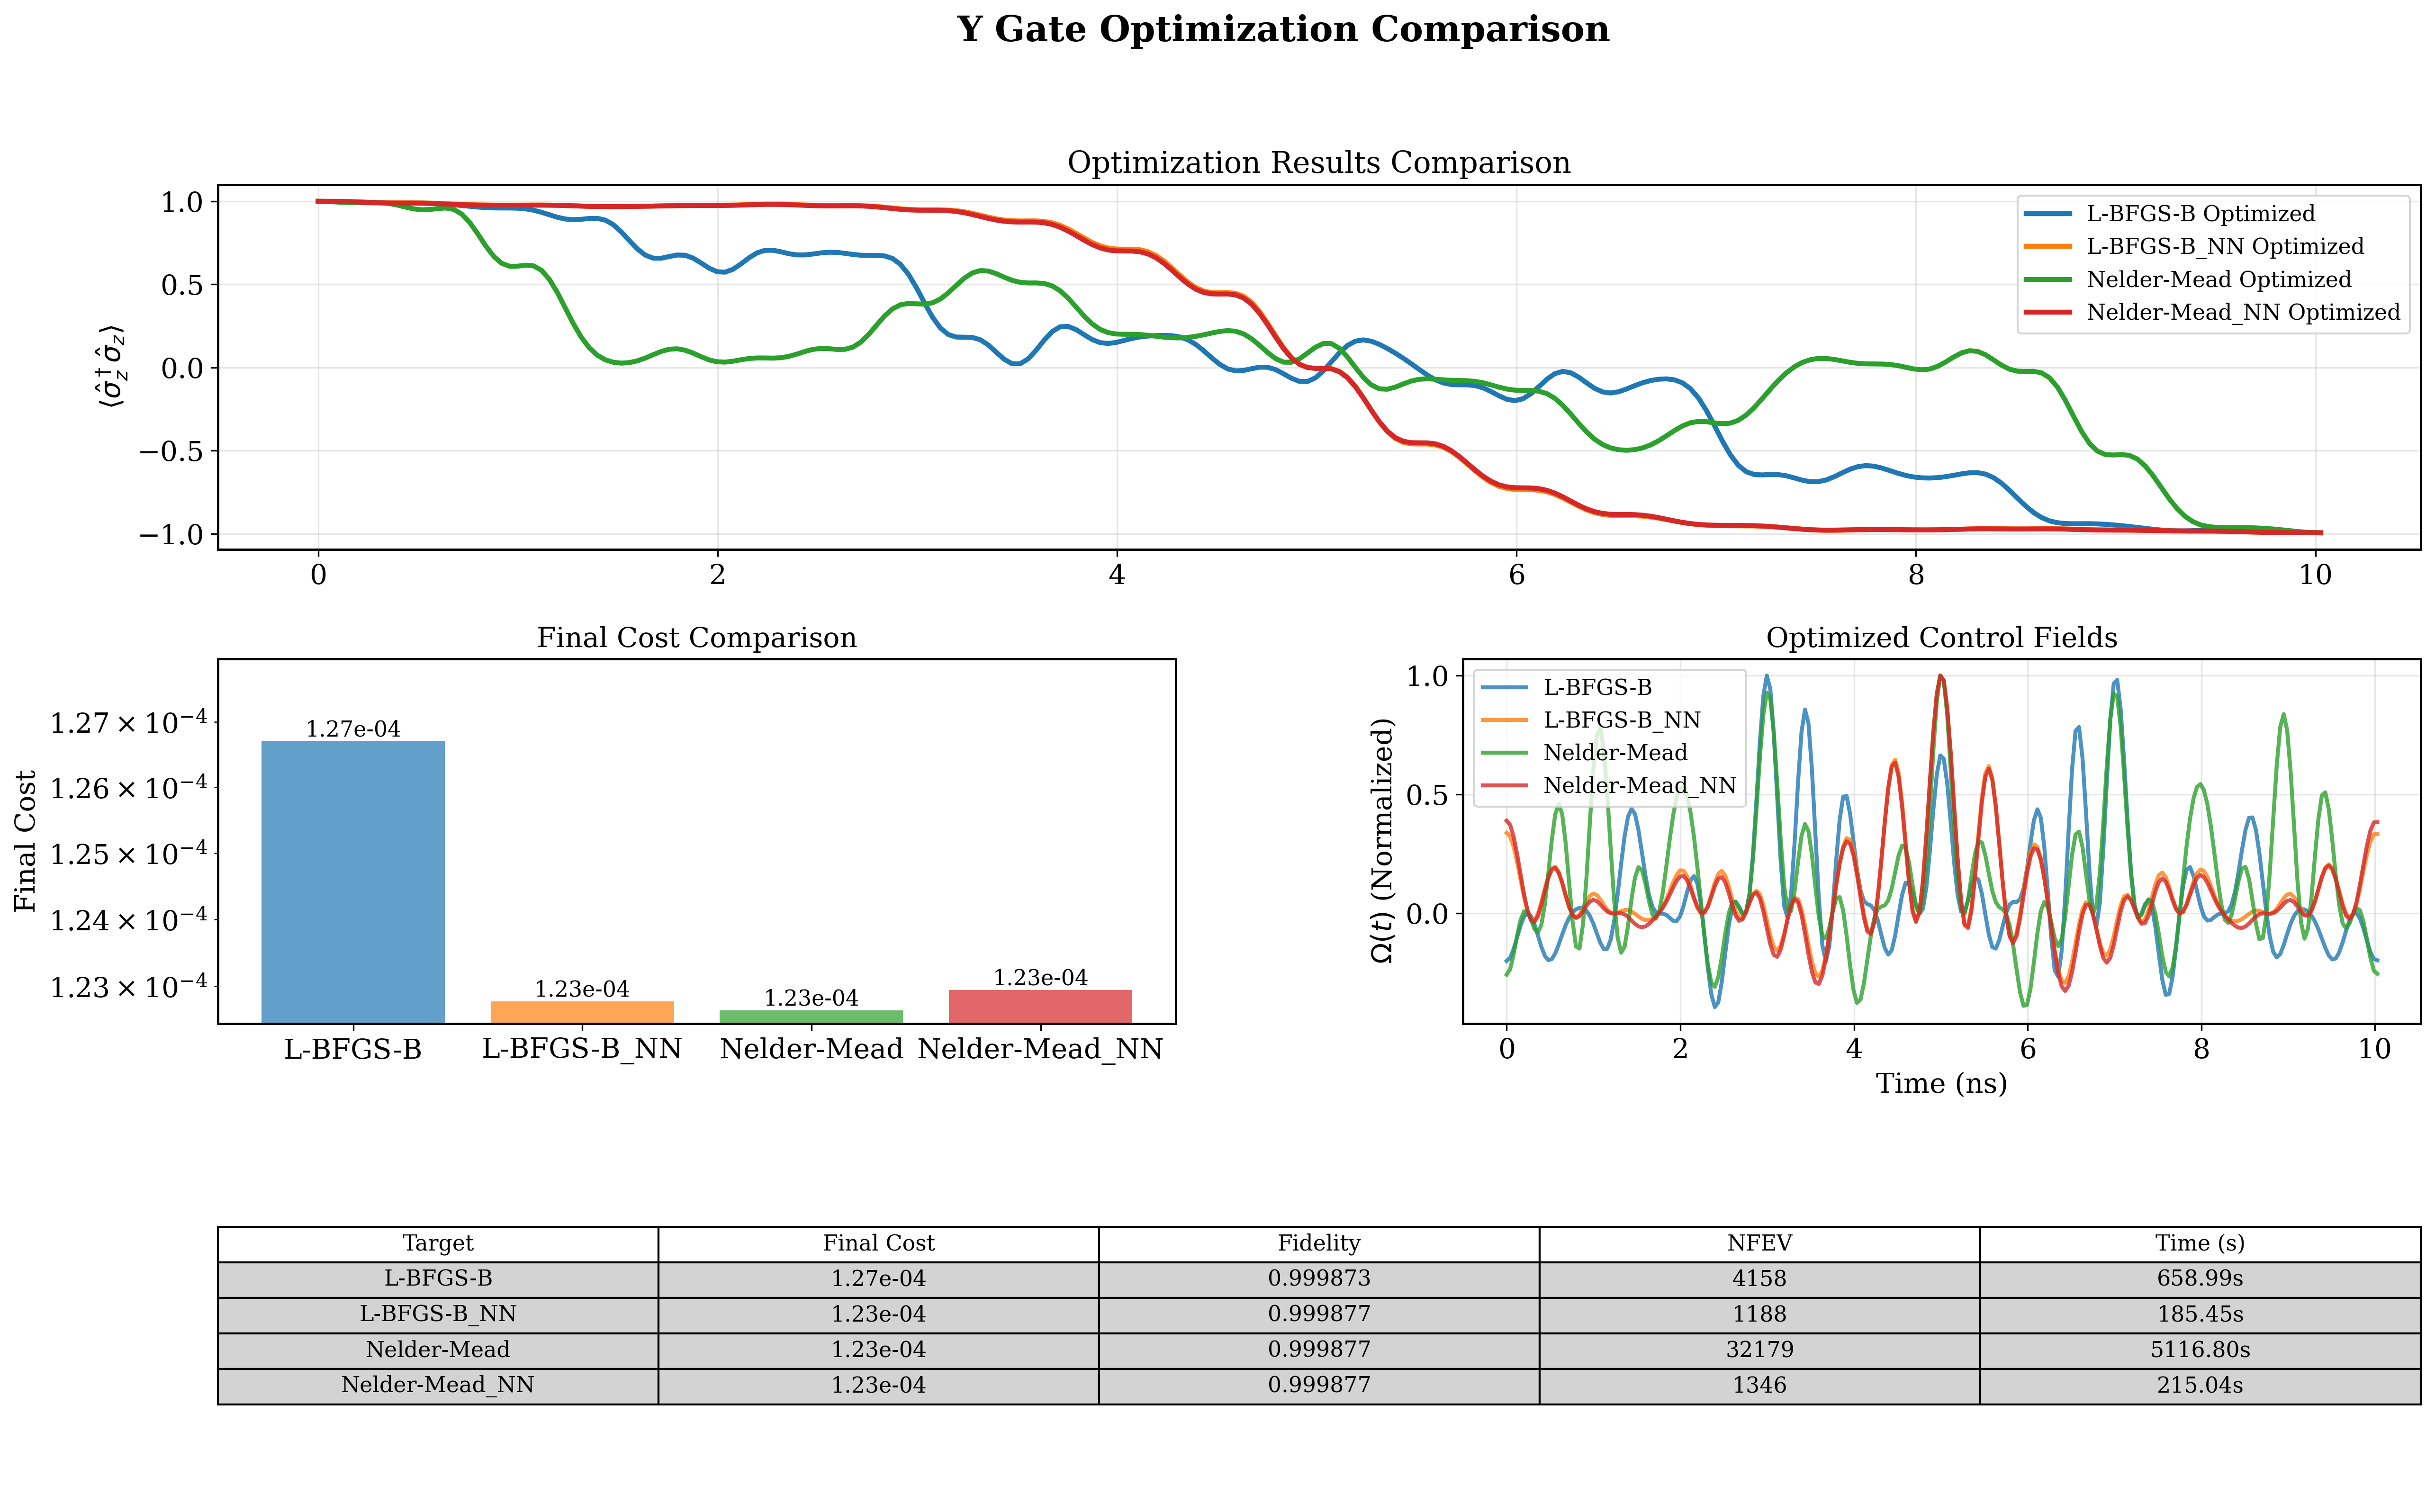

In [15]:
y_comparison_data = {
    'L-BFGS-B':{
        'final_cost': y_opt_cost,
        'optimized': ez_y,
        'fidelity': y_opt_fid,
        'nfev': y_opt_res['nfev'],
        'optimization_time': gate_results['y_gate']['time_elapsed'],
        'control_field': control_field_y
    },
    'L-BFGS-B_NN':{
        'final_cost': y_opt_cost_NN,
        'optimized': ez_y_NN,
        'fidelity': y_opt_fid_NN,
        'nfev': y_opt_res_NN['nfev'],
        'optimization_time': gate_results['y_gate_NN']['time_elapsed'],
        'control_field': control_field_y_NN
    },
    'Nelder-Mead':{
        'final_cost': y_opt_cost_nm,
        'optimized': ez_y_nm,
        'fidelity': y_opt_fid_nm,
        'nfev': y_opt_res_nm['nfev'],
        'optimization_time': gate_results['y_gate_nm']['time_elapsed'],
        'control_field': control_field_y_nm
    },
    'Nelder-Mead_NN':{
        'final_cost': y_opt_cost_nm_NN,
        'optimized': ez_y_nm_NN,
        'fidelity': y_opt_fid_nm_NN,
        'nfev': y_opt_res_nm_NN['nfev'],
        'optimization_time': gate_results['y_gate_nm_NN']['time_elapsed'],
        'control_field': control_field_y_nm_NN
    }
}

gate_plotter.create_summary_figure(
    time_points=time_array,
    results_data=y_comparison_data,
    title='Y Gate Optimization Comparison',
    filename='y_gate_comparison'
)
